# **Hidden Markov Model & Sequence Analysis**

Compute this to install the necessary libraries and mount google drive

In [ ]:
# @title Install
!pip install hmmlearn
!pip install graphviz
from google.colab import drive
drive.mount('/content/drive')

### **Automatized version for excel file**

In this version, while running it on google colab you must have the excel file "iterations_transitions_accuracy.xlsx" in your google drive. Then you can choose the nuber of the sequence you want to compute the if you write "1" it will compute the first sequence of the excel file (excel's row 2). So for example if you want to compute the sequence on row 200 of the excel file you should write "199" when running the code.

Number of the sequence to process (excel row -1): 18

Processing sequence from excel's row 19: WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN

<ipython-input-11-ba3940ae471c>:58: RuntimeWarning: invalid value encountered in divide
  transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)


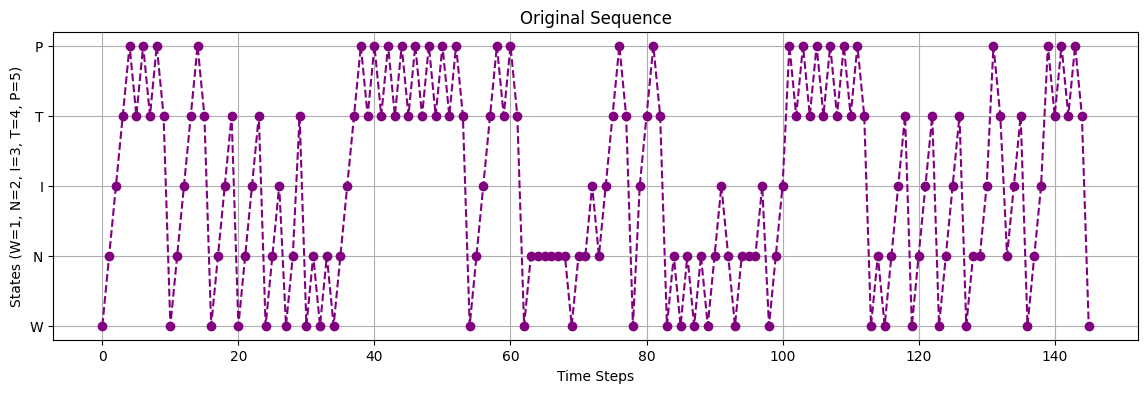


Transition count matrix : 0, 24, 1, 0, 0, 8, 9, 18, 1, 0, 2, 2, 0, 12, 3, 15, 1, 0, 0, 23, 0, 0, 0, 26, 0


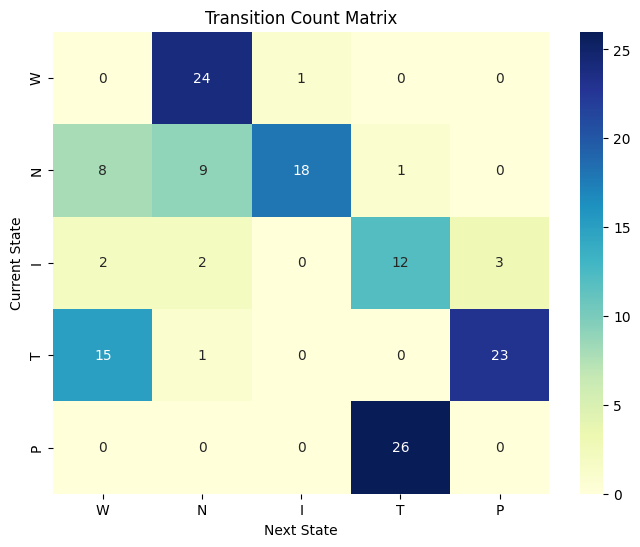

<ipython-input-11-ba3940ae471c>:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.96])


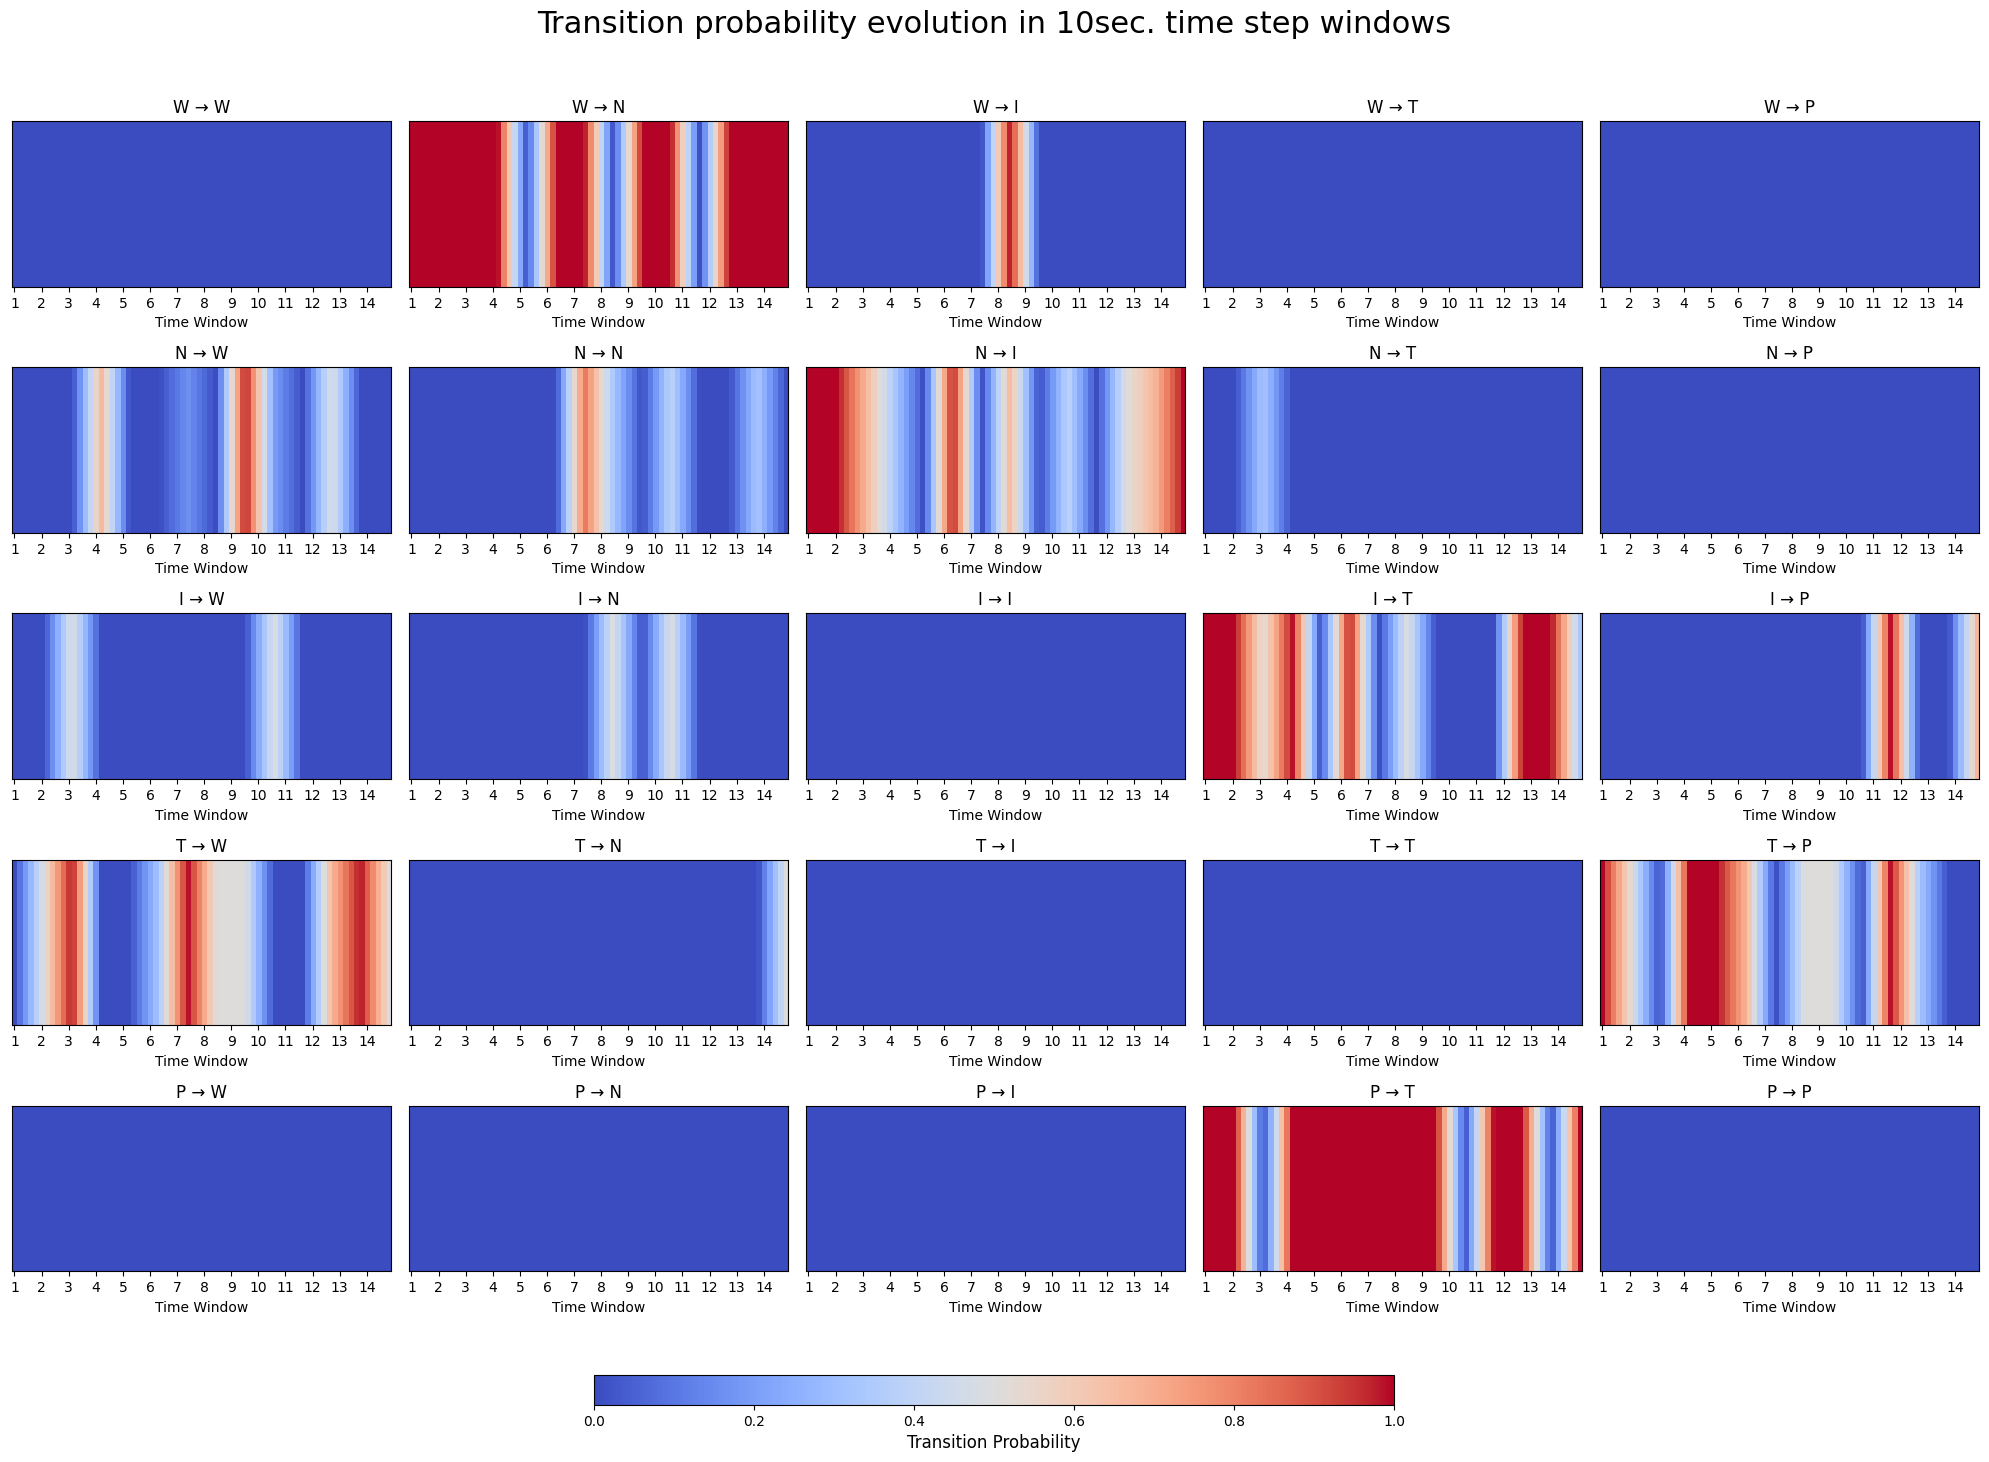

In [11]:
import pandas as pd
from scipy.ndimage import zoom
import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from graphviz import Digraph
import seaborn as sns

file_path = '/content/drive/My Drive/iterations_transitions_accuracy.xlsx'
df = pd.read_excel(file_path, sheet_name='Feuil1')
sequences = df.iloc[0:, 13].dropna().tolist()

def convert_sequence(sequence):
    filtered_sequence = [sequence[0]] + [sequence[i] for i in range(1, len(sequence)) if sequence[i] != sequence[i - 1]]
    #filtered_sequence = input_sequence #turn on if you want to enable state to itself transitions
    return [1 if char == 'W' else
            2 if char == 'N' else
            3 if char == 'I' else
            4 if char == 'T' else
            5 if char == 'P' else
            1 if char == 1 else
            2 if char == 2 else
            3 if char == 3 else
            4 if char == 4 else
            5 if char == 5 else
            None for char in filtered_sequence]

# AUTOMATIZATION
row_num = int(input(f"Number of the sequence to process (excel row -1): "))
sequence = sequences[row_num - 1]
print("")
print(f"Processing sequence from excel's row {row_num+1}: {sequence}")
original_sequence = convert_sequence(sequence)
original_sequence = [value for value in original_sequence if value is not None]

# Define number of states and time window size
n_states = 5
time_step_window = 10

# Number of transitions calculation
transitions = 0
for i in range(1, len(original_sequence)):
    if original_sequence[i] != original_sequence[i - 1]:
        transitions += 1

# Transition matrices for each window
transition_matrices = []
num_windows = len(original_sequence) // time_step_window

for w in range(num_windows):
    window_sequence = original_sequence[w * time_step_window:(w + 1) * time_step_window]
    transition_matrix = np.zeros((n_states, n_states))

    for (current_state, next_state) in zip(window_sequence[:-1], window_sequence[1:]):
        transition_matrix[current_state - 1, next_state - 1] += 1
    transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)
    transition_matrices.append(transition_matrix)

print(f"Number of transitions between states: {transitions}")
print("")
plt.figure(figsize=(14, 4))
plt.plot(original_sequence, color='purple', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("States (W=1, N=2, I=3, T=4, P=5)")
plt.yticks([1, 2, 3, 4, 5], labels=['W', 'N', 'I', 'T', 'P'])
plt.grid(True)
plt.show()

# Transition count matrix
transition_count_matrix = np.zeros((n_states, n_states))
for (current_state, next_state) in zip(original_sequence[:-1], original_sequence[1:]):
    transition_count_matrix[current_state - 1, next_state - 1] += 1

transition_count_string = ', '.join([', '.join(map(lambda x: str(int(x)), row)) for row in transition_count_matrix])
print("")
print(f"Transition count matrix : {transition_count_string}")

state_labels = ['W', 'N', 'I', 'T', 'P']
plt.figure(figsize=(8, 6))
sns.heatmap(transition_count_matrix, annot=True, fmt=".0f", cmap="YlGnBu",
                xticklabels=state_labels, yticklabels=state_labels)
plt.title("Transition Count Matrix")
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.show()
print("")

# Heatmaps
fig, axes = plt.subplots(n_states, n_states, figsize=(20, 15))
for i in range(n_states):
    for j in range(n_states):
        probabilities = [matrix[i, j] for matrix in transition_matrices]
        probabilities = np.nan_to_num(probabilities, nan=0.0)
        probability_array = np.array(probabilities).reshape(1, -1)
        smooth_array = zoom(probability_array, (1, 5), order=1)
        im = axes[i, j].imshow(smooth_array, aspect='auto', cmap='coolwarm', vmin=0, vmax=1)
        axes[i, j].set_title(f'{state_labels[i]} → {state_labels[j]}')
        axes[i, j].set_yticks([])
        axes[i, j].set_xticks(range(0, smooth_array.shape[1], 5))
        axes[i, j].set_xticklabels(range(1, num_windows + 1))
        axes[i, j].set_xlabel("Time Window")

cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02])
fig.colorbar(im, cax=cbar_ax, orientation="horizontal").set_label("Transition Probability", fontsize=12)
fig.suptitle('Transition probability evolution in 10sec. time step windows', fontsize=22)
plt.tight_layout(rect=[0, 0.1, 1, 0.96])
plt.show()

### **Automatized version for the entire excel table (long computing)**

This version produces the same outputs as above but here it goes trough the entire table. It takes around 20 minutes to compute trough all the sequences.

In [ ]:
!pip install hmmlearn
!pip install graphviz
import pandas as pd
from scipy.ndimage import zoom
import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from graphviz import Digraph
import seaborn as sns

loop_count=0

file_path = '/content/drive/My Drive/iterations_transitions_accuracy.xlsx'
df = pd.read_excel(file_path, sheet_name='Feuil1')
sequences = df.iloc[0:, 13].dropna().tolist()

def convert_sequence(sequence):
    filtered_sequence = [sequence[0]] + [sequence[i] for i in range(1, len(sequence)) if sequence[i] != sequence[i - 1]]
    #filtered_sequence = input_sequence #turn on if you want to enable state to itself transitions
    return [1 if char == 'W' else
            2 if char == 'N' else
            3 if char == 'I' else
            4 if char == 'T' else
            5 if char == 'P' else
            1 if char == 1 else
            2 if char == 2 else
            3 if char == 3 else
            4 if char == 4 else
            5 if char == 5 else
            None for char in filtered_sequence]

# Loop
for input_sequence in sequences:
    print("")
    loop_count+=1
    print(f"Sequence no. {loop_count}")
    print(f"Processing sequence: {input_sequence}")

    original_sequence = convert_sequence(input_sequence)
    original_sequence = [value for value in original_sequence if value is not None]
    original_sequence = convert_sequence(original_sequence)

    n_states = 5
    time_step_window = 10

    transitions = 0
    for i in range(1, len(original_sequence)):
        if original_sequence[i] != original_sequence[i - 1]:
            transitions += 1

    transition_matrices = []
    num_windows = len(original_sequence) // time_step_window

    for w in range(num_windows):
        window_sequence = original_sequence[w * time_step_window:(w + 1) * time_step_window]
        transition_matrix = np.zeros((n_states, n_states))

        for (current_state, next_state) in zip(window_sequence[:-1], window_sequence[1:]):
            transition_matrix[current_state - 1, next_state - 1] += 1
        transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)
        transition_matrices.append(transition_matrix)

    print(f"Number of transitions between states: {transitions}")
    plt.figure(figsize=(14, 4))
    plt.plot(original_sequence, color='purple', marker='o', linestyle='dashed')
    plt.title("Original Sequence")
    plt.xlabel("Time Steps")
    plt.ylabel("States (W=1, N=2, I=3, T=4, P=5)")
    plt.yticks([1, 2, 3, 4, 5], labels=['W', 'N', 'I', 'T', 'P'])
    plt.grid(True)
    plt.show()

    transition_count_matrix = np.zeros((n_states, n_states))
    for (current_state, next_state) in zip(original_sequence[:-1], original_sequence[1:]):
        transition_count_matrix[current_state - 1, next_state - 1] += 1

    transition_count_string = ', '.join([', '.join(map(lambda x: str(int(x)), row)) for row in transition_count_matrix])
    print(transition_count_string)

    state_labels = ['W', 'N', 'I', 'T', 'P']
    plt.figure(figsize=(8, 6))
    sns.heatmap(transition_count_matrix, annot=True, fmt=".0f", cmap="YlGnBu",
                xticklabels=state_labels, yticklabels=state_labels)
    plt.title("Transition Count Matrix")
    plt.xlabel("Next State")
    plt.ylabel("Current State")
    plt.show()

    fig, axes = plt.subplots(n_states, n_states, figsize=(20, 15))
    for i in range(n_states):
        for j in range(n_states):
            probabilities = [matrix[i, j] for matrix in transition_matrices]
            probabilities = np.nan_to_num(probabilities, nan=0.0)
            probability_array = np.array(probabilities).reshape(1, -1)
            smooth_array = zoom(probability_array, (1, 5), order=1)
            im = axes[i, j].imshow(smooth_array, aspect='auto', cmap='coolwarm', vmin=0, vmax=1)
            axes[i, j].set_title(f'{state_labels[i]} → {state_labels[j]}')
            axes[i, j].set_yticks([])
            axes[i, j].set_xticks(range(0, smooth_array.shape[1], 5))
            axes[i, j].set_xticklabels(range(1, num_windows + 1))
            axes[i, j].set_xlabel("Time Window")

    cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02])
    fig.colorbar(im, cax=cbar_ax, orientation="horizontal").set_label("Transition Probability", fontsize=12)
    fig.suptitle('Heatmaps', fontsize=22)
    plt.tight_layout(rect=[0, 0.1, 1, 0.96])
    plt.show()

### **OTHER VERSIONS :**

## **Week 9**

### *Heatmaps (same as above but not automatized)*

In [ ]:
from scipy.ndimage import zoom
import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from graphviz import Digraph
import seaborn as sns
import pandas as pd

def convert_sequence(sequence):
    filtered_sequence = [sequence[0]] + [sequence[i] for i in range(1, len(sequence)) if sequence[i] != sequence[i - 1]]
    #filtered_sequence = input_sequence #turn on if you want to enable state to itself transitions
    return [1 if char == 'W' else
            2 if char == 'N' else
            3 if char == 'I' else
            4 if char == 'T' else
            5 if char == 'P' else
            1 if char == 1 else
            2 if char == 2 else
            3 if char == 3 else
            4 if char == 4 else
            5 if char == 5 else
            None for char in filtered_sequence]


input_sequence = input("seq: ")
original_sequence = convert_sequence(input_sequence)
original_sequence = [value for value in original_sequence if value is not None]
original_sequence = convert_sequence(original_sequence)

n_states = 5
time_step_window = 10  # WINDOW SIZE

# NUMBER OF TRANSITIONS
transitions = 0
for i in range(1, len(original_sequence)):
    if original_sequence[i] != original_sequence[i - 1]:
        transitions += 1

# Calculate Transition Matrices for Each 10-Time-Step Window
transition_matrices = []
num_windows = len(original_sequence) // time_step_window

for w in range(num_windows):
    window_sequence = original_sequence[w * time_step_window:(w + 1) * time_step_window]
    transition_matrix = np.zeros((n_states, n_states))

    for (current_state, next_state) in zip(window_sequence[:-1], window_sequence[1:]):
        transition_matrix[current_state - 1, next_state - 1] += 1
    # Normalize transition matrix
    transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)
    transition_matrices.append(transition_matrix)

# SEQUENCE PLOT ----------------------------------------------------------------

print(f"Number of transitions between states: {transitions}")
print("")
plt.figure(figsize=(14, 4))
plt.plot(original_sequence, color='purple', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("States (W=1, N=2, I=3, T=4, P=5)")
plt.yticks([1, 2, 3, 4, 5], labels=['W', 'N', 'I', 'T', 'P'])
plt.grid(True)
plt.show()
print("")

# TRANSITION COUNT MATRIX ------------------------------------------------------
transition_count_matrix = np.zeros((n_states, n_states))

for (current_state, next_state) in zip(original_sequence[:-1], original_sequence[1:]):
    transition_count_matrix[current_state - 1, next_state - 1] += 1

transition_count_string = ', '.join([', '.join(map(lambda x: str(int(x)), row)) for row in transition_count_matrix])
print(transition_count_string)

state_labels = ['W', 'N', 'I', 'T', 'P']

plt.figure(figsize=(8, 6))
sns.heatmap(transition_count_matrix, annot=True, fmt=".0f", cmap="YlGnBu", cbar=True,
            xticklabels=state_labels, yticklabels=state_labels)
plt.title("Transition Count Matrix")
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.show()

# HEATMAPS ---------------------------------------------------------------------
fig, axes = plt.subplots(n_states, n_states, figsize=(20, 15))

for i in range(n_states):
    for j in range(n_states):
        probabilities = [matrix[i, j] for matrix in transition_matrices]
        probabilities = np.nan_to_num(probabilities, nan=0.0)
        probability_array = np.array(probabilities).reshape(1, -1)
        smooth_array = zoom(probability_array, (1, 5), order=1)
        im = axes[i, j].imshow(smooth_array, aspect='auto', cmap='coolwarm', vmin=0, vmax=1)
        axes[i, j].set_title(f'{state_labels[i]} → {state_labels[j]}')
        axes[i, j].set_yticks([])
        axes[i, j].set_xticks(range(0, smooth_array.shape[1], 5))
        axes[i, j].set_xticklabels(range(1, num_windows + 1))
        axes[i, j].set_xlabel("Time Window")

cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Transition Probability", fontsize=12)

fig.suptitle('Transition probability evolution for 10-time-step windows', fontsize=22)
plt.tight_layout(rect=[0, 0.1, 1, 0.96])
plt.show()

## **Week 8**

### *Whole table all states (most complete HMM version)*

This code, having the hmm setup to suit the type of sequences from the xlsx file, achieves between 100% and 60% of prediction accuracy. It has been automatized but can be switched to manual if you delete the automatic part of the code and remove the """ around the manual part.

Number of the sequence to process (excel row -1): 266


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



Processing sequence from excel's row 267: _WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWWWWNNNNNNNNNWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNI

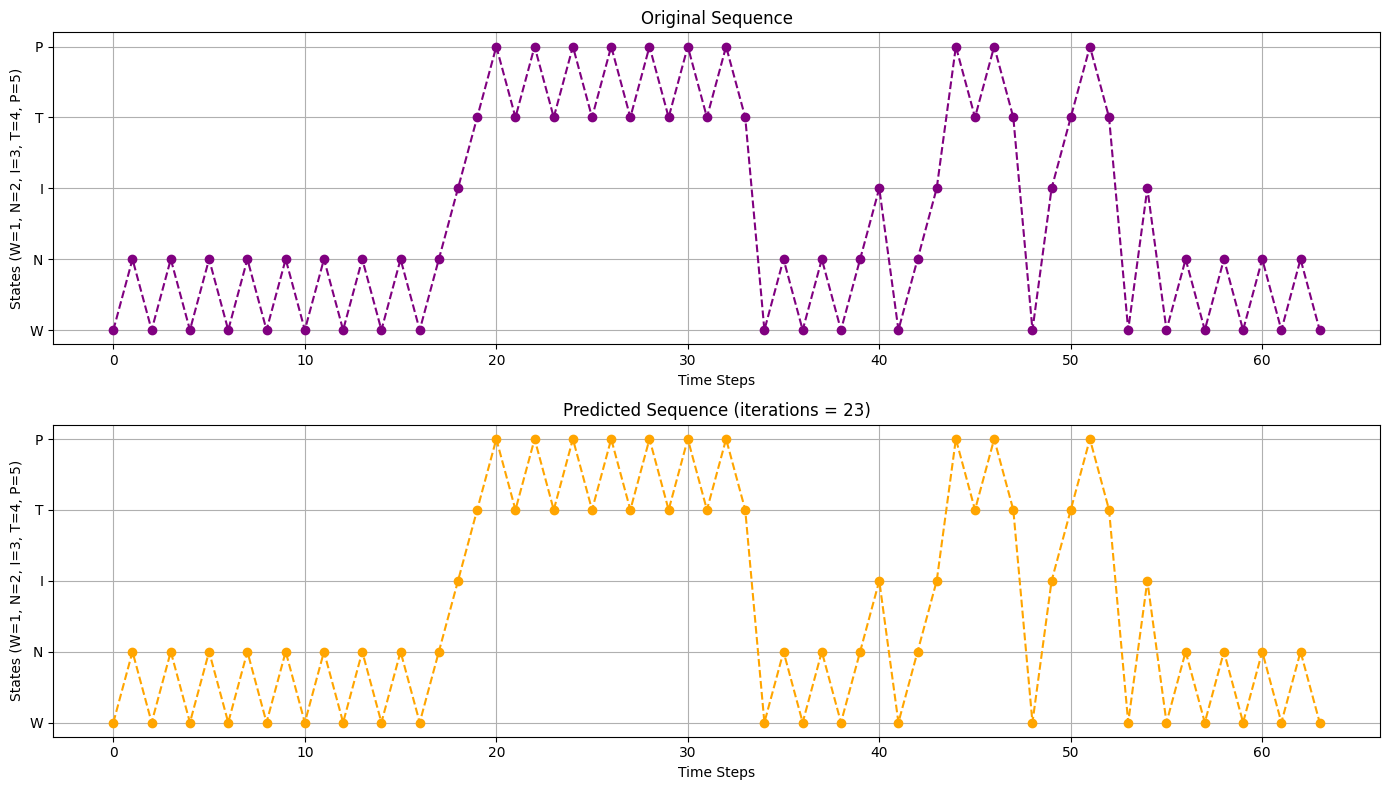


TRANSITION PROBABILITIES:
W → W: 0.0000
W → N: 0.9116
W → I: 0.0884
W → T: 0.0000
W → P: 0.0000
N → W: 0.8268
N → N: 0.0000
N → I: 0.1732
N → T: 0.0000
N → P: 0.0000
I → W: 0.3590
I → N: 0.0000
I → I: 0.0000
I → T: 0.4273
I → P: 0.2137
T → W: 0.2500
T → N: 0.0000
T → I: 0.0000
T → T: 0.0000
T → P: 0.7500
P → W: 0.0000
P → N: 0.0000
P → I: 0.0000
P → T: 1.0000
P → P: 0.0000



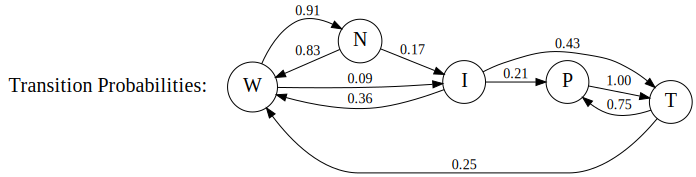

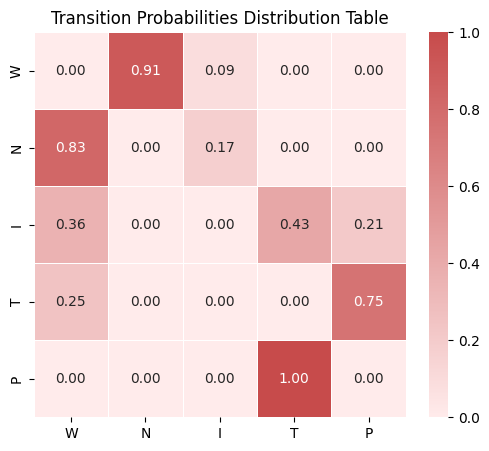

In [4]:
"""
To setup the HMM model :
- change n_states to the number of hidden states in the sequence
- in the EMISSION MATRIX init. adjust its randomness by changing the
  multiplication coefficient (*1.421 in this specific case)
- adjust the MAXIMUM number of iterations max_iterations if necessary
- if you want to add 'state to itself repetitions', remove the "#" before the
  filtered_sequence=sequence line in the convert_sequence function

Reminder:
Run the !pip install lines the first time to install the libraries

"""

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from graphviz import Digraph
import seaborn as sns
import pandas as pd

file_path = '/content/drive/My Drive/iterations_transitions_accuracy.xlsx'
df = pd.read_excel(file_path, sheet_name='Feuil1')
sequences = df.iloc[0:, 13].dropna().tolist()

# ORIGINAL SEQUENCES -----------------------------------------------------------

def convert_sequence(sequence):
    filtered_sequence = [sequence[0]] + [sequence[i] for i in range(1, len(sequence)) if sequence[i] != sequence[i - 1]]
    #filtered_sequence=sequence
    return [1 if char == 'W' else
            2 if char == 'N' else
            3 if char == 'I' else
            4 if char == 'T' else
            5 if char == 'P' else
            None for char in filtered_sequence]
# MANUAL
"""
input_sequence = input("seq: ")
original_sequence = convert_sequence(input_sequence)
original_sequence = [value for value in original_sequence if value is not None]

print("Filtered sequence:", original_sequence)
"""

# AUTOMATIZED
row_num = int(input(f"Number of the sequence to process (excel row -1): "))
sequence = sequences[row_num - 1]  # Adjust row number to match the zero-indexed list
print("")
print(f"Processing sequence from excel's row {row_num+1}: {sequence}")
original_sequence = convert_sequence(sequence)
original_sequence = [value for value in original_sequence if value is not None]


# ------------------------------------------------------------------------------

original_sequence = np.array(original_sequence)
#n_states = int(input("n_states: "))  # Number of hidden states
n_states = 5
n_features = n_states

# NUMBER OF TRANSITIONS
transitions = 0
for i in range(1, len(original_sequence)):
    if original_sequence[i] != original_sequence[i - 1]:
        transitions += 1

# TRANSITION MATRIX
np.random.seed(42)  # ensuring reproducibility
transition_matrix = np.random.rand(n_states, n_states)  # Completely random transition matrix
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

# EMISSION MATRIX init. (slightly randomized identity matrix)
emission_matrix = np.eye(n_states, n_features) + np.random.rand(n_states, n_features)*1.421
emission_matrix /= emission_matrix.sum(axis=1, keepdims=True)


# Convert observed sequence to 0-based indexing & set up observed counts for HMM
observed_sequence = (original_sequence - 1).reshape(-1, 1)
observed_counts = np.zeros((observed_sequence.shape[0], n_states), dtype=int)
for i in range(observed_sequence.shape[0]):
    observed_counts[i, observed_sequence[i, 0]] = 1

# HMM MODEL SETUP
model = hmm.MultinomialHMM(n_components=n_states, tol=0.0001, n_iter=10, random_state=42, init_params='')

# RANDOM START PROBABILITIES
startprob = np.random.rand(n_states)
startprob /= startprob.sum()
model.startprob_ = startprob

model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix

# TRAINING ---------------------------------------------------------------------
iterations = 0
accuracy = 0
max_accuracy = 0
max_iterations = 400  # can change that depending on the dataset
while accuracy < 1.0 and iterations < max_iterations:
    iterations += 1
    model.fit(observed_counts)
    predicted_sequence = model.predict(observed_counts) + 1
    accuracy = accuracy_score(original_sequence, predicted_sequence)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
    print(f"Iteration {iterations}: {accuracy * 100:.2f}%")

# OUTPUTS ----------------------------------------------------------------------

print(f"\nTraining stopped at {iterations} iterations.")
print("")
#print(f"input : {input_sequence}")
print(f"Accuracy (max. reached by predicted sequence): {max_accuracy * 100:.2f}%")
print(f"Number of transitions between states: {transitions}")
print("")

plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(original_sequence, color='purple', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("States (W=1, N=2, I=3, T=4, P=5)")
plt.yticks([1, 2, 3, 4, 5], labels=['W', 'N', 'I', 'T', 'P'])
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(predicted_sequence, color='orange', marker='o', linestyle='dashed')
plt.title(f"Predicted Sequence (iterations = {iterations})")
plt.xlabel("Time Steps")
plt.ylabel("States (W=1, N=2, I=3, T=4, P=5)")
plt.yticks([1, 2, 3, 4, 5], labels=['W', 'N', 'I', 'T', 'P'])
plt.grid(True)

plt.tight_layout()
plt.show()


print("\nTRANSITION PROBABILITIES:")
for i, state1 in enumerate(['W', 'N', 'I', 'T', 'P']):
    for j, state2 in enumerate(['W', 'N', 'I', 'T', 'P']):
        print(f"{state1} → {state2}: {model.transmat_[i, j]:.4f}")

# TRANSITION GRAPH
print("")
# Initialize the directed graph
dot = Digraph(format='png', graph_attr={'rankdir': 'LR'})

# Title for the graph
with dot.subgraph() as s:
    s.attr(rank='source')
    s.node('title', label='Transition Probabilities:', shape='plaintext', fontsize='20', fontcolor='black')

# Define the nodes for each state
states = ['W', 'N', 'I', 'T', 'P']
for state in states:
    dot.node(state, label=state, shape='circle', style='filled', fillcolor='white', fontcolor='black', fontsize='20')

# Add edges based on non-zero transition probabilities
for i, state1 in enumerate(states):
    for j, state2 in enumerate(states):
        probability = model.transmat_[i, j]
        if probability > 0.001:
            dot.edge(state1, state2, label=f'{probability:.2f}', color='black', penwidth='1', fontcolor='black')

# Display the graph
display(dot)

# PROBABILITY DISTRIBUTION TABLE
proba_matrix = model.transmat_[:5, :5]
proba_matrix_df = pd.DataFrame(proba_matrix,
                               columns=['W', 'N', 'I', 'T', 'P'],
                               index=['W', 'N', 'I', 'T', 'P'])

colors = ["#FFEBEB", "#C74B4B"]
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)

plt.figure(figsize=(6, 5))
sns.heatmap(proba_matrix_df, annot=True, fmt=".2f", cmap=cmap, cbar=True,
            linewidths=0.5, linecolor='white')

plt.title('Transition Probabilities Distribution Table')
plt.show()

## **Week 7**

This is an older version of the Week 8 code with less features. It was used for the first full table analysis, having the hmm model setup to high performance results (close to 100% accuracy). This version is not automatized, thus the sequence has to be ctrl+c ctrl+v in the code.

In [ ]:
"""
Working for data in the sting_analysis_hypno.csv file

"""

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from graphviz import Digraph
import seaborn as sns
import pandas as pd

# ORIGINAL SEQUENCES -----------------------------------------------------------

def convert_sequence(sequence):
  return [1 if char == 'W' else 2 if char == 'N' else 3 if char == 'I' else 4 if char == 'T' else 5 if char =='P' else 6 for char in sequence]
input_sequence = "_WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWWWWNNNNNNNNNWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIITTTTTTPPPPPTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTPPTTTTTTTTTTPPTTTTTTTTTTPPTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTPTTTTTPTTTTTTTTTTTTTTTTTTTTPPTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNIIIIIIIIIIIIIIIIIIIIIWWWWWWWWWWWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIPPTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTPPTTTWWWWWWWWWWWWIIIIIIIIIIIIIIIIIIIIIIIIIIIIITTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTPPTTTTWWWWWWIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIWWWWWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWW"
original_sequence = convert_sequence(input_sequence)

# ------------------------------------------------------------------------------

original_sequence = np.array(original_sequence)
n_states = 6 # Number of hidden states

# NUMBER OF TRANSITIONS
transitions = 0
for i in range(1, len(original_sequence)):
    if original_sequence[i] != original_sequence[i - 1]:
        transitions += 1

# TRANSITION MATRIX
transition_matrix = np.zeros((n_states, n_states))
for (current_state,next_state) in zip(original_sequence[:-1],original_sequence[1:]):
    transition_matrix[current_state - 1, next_state - 1] += 1
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

# EMISSION MATRIX
emission_matrix = np.eye(n_states)

# Convert observed sequence to 0-based indexing & set up observed counts for HMM
observed_sequence = (original_sequence - 1).reshape(-1, 1)
observed_counts = np.zeros((observed_sequence.shape[0], n_states), dtype=int)
for i in range(observed_sequence.shape[0]):
    observed_counts[i, observed_sequence[i, 0]] = 1

# HMM MODEL SETUP
model = hmm.MultinomialHMM(n_components=n_states,tol=0.01,random_state=42,init_params='')
start_state = original_sequence[0] - 1
model.startprob_ = np.zeros(n_states)
model.startprob_[start_state] = 1
model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix

# TRAINING ---------------------------------------------------------------------
iterations = 0
accuracy = 0
while accuracy < 1.0:
    iterations += 1
    model.fit(observed_counts)
    predicted_sequence = model.predict(observed_counts) + 1
    accuracy = accuracy_score(original_sequence, predicted_sequence)
    print(f"Iteration {iterations}:{accuracy * 100:.2f}%")

# OUTPUTS ----------------------------------------------------------------------
# ------------------------------------------------------------------------------

print(f"\nTraining completed in {iterations} iterations.")
print("")
print(f"input : {input_sequence}")
#print(f"Original Sequence: {original_sequence}")
#print(f"Predicted Sequence: {predicted_sequence}")
print(f"Accuracy (predicted sequence): {accuracy * 100:.2f}%")
print(f"Number of transitions between states: {transitions}")
print("")


plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(original_sequence, color='purple', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("States (W=1, N=2, I=3, T=4, P=5)")
#plt.xticks(np.arange(0, len(original_sequence), step=100))
plt.yticks([1, 2, 3, 4, 5], labels=['W', 'N', 'I', 'T', 'P'])
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(predicted_sequence, color='orange', marker='o', linestyle='dashed')
plt.title(f"Predicted Sequence (iterations = {iterations})")
plt.xlabel("Time Steps")
plt.ylabel("States (W=1, N=2, I=3, T=4, P=5)")
#plt.xticks(np.arange(0, len(predicted_sequence), step=100))
plt.yticks([1, 2, 3, 4, 5], labels=['W', 'N', 'I', 'T', 'P'])
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nTRANSITION PROBABILITIES:")
for i, state1 in enumerate(['W', 'N', 'I', 'T', 'P']):
    for j, state2 in enumerate(['W', 'N', 'I', 'T', 'P']):
        print(f"{state1} → {state2}: {transition_matrix[i, j]:.4f}")

# TRANSITION GRAPH
print("")
dot = Digraph(format='png', graph_attr={'rankdir': 'LR'})

with dot.subgraph() as s:
    s.attr(rank='source')
    s.node('title', label='Transition Probabilities:', shape='plaintext', fontsize='20', fontcolor='black')

dot.node('W', label='W', shape='circle', style='filled', fillcolor='white', fontcolor='black', fontsize='20')
dot.node('N', label='N', shape='circle', style='filled', fillcolor='white', fontcolor='black', fontsize='20')
dot.node('I', label='I', shape='circle', style='filled', fillcolor='white', fontcolor='black', fontsize='20')
dot.node('T', label='T', shape='circle', style='filled', fillcolor='white', fontcolor='black', fontsize='20')
dot.node('P', label='P', shape='circle', style='filled', fillcolor='white', fontcolor='black', fontsize='20')

for i, state1 in enumerate(['W', 'N', 'I', 'T', 'P']):
    for j, state2 in enumerate(['W', 'N', 'I', 'T', 'P']):
        if transition_matrix[i, j] > 0:
            dot.edge(state1, state2, label=f'{transition_matrix[i, j]:.2f}', color='black', penwidth='1', fontcolor='black')

display(dot)

# PROBABILITY DISTRIBUTION TABLE
proba_matrix = transition_matrix[:5, :5]
proba_matrix_df = pd.DataFrame(proba_matrix,
                               columns=['W', 'N', 'I', 'T', 'P'],
                               index=['W', 'N', 'I', 'T', 'P'])

colors = ["#FFEBEB", "#C74B4B"]
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)

plt.figure(figsize=(6, 5))
sns.heatmap(proba_matrix_df, annot=True, fmt=".2f", cmap=cmap, cbar=True,
            linewidths=0.5, linecolor='white')

plt.title('Transition Probabilities Distribution Table')
plt.show()

## **Week 6**

### *HMM code for phasic & tonic*

seq: TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTPTTTTTTTTTTTTTTTTPTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTPTP


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Iteration 1:96.08%
Iteration 2:99.02%
Iteration 3:100.00%

Training completed in 3 iterations.

Accuracy (predicted sequence): 100.00%
Number of transitions between states: 7



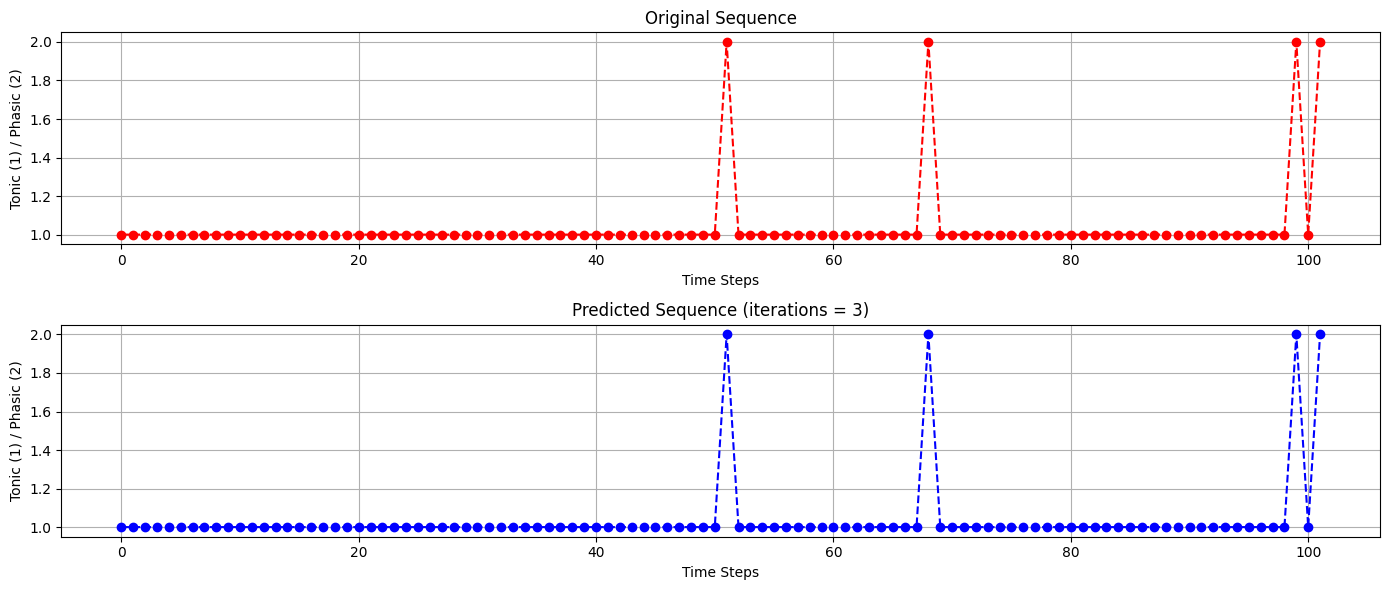


TRANSITION PROBABILITIES:
Staying in Tonic (1 → 1): 0.9592
Tonic to Phasic (1 → 2): 0.0408
Phasic to Tonic (2 → 1): 1.0000
Staying in Phasic (2 → 2): 0.0000



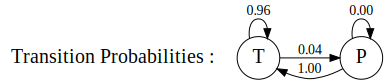

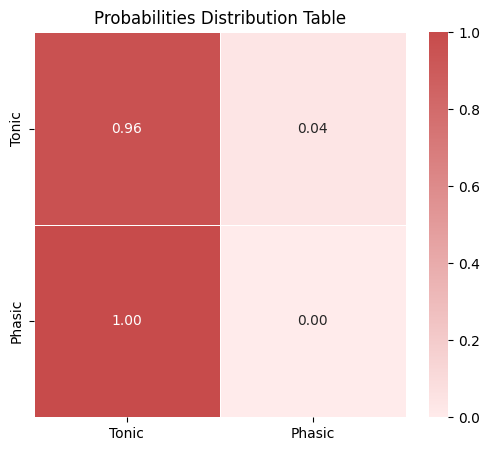

In [8]:
"""
Adds automatic iterations counting & transition plots
Removed not used features for phasic/tonic analysis cf. Week 5 version
Adds char sequence to array converter in # ORIGINAL SEQUENCES section

"""

#!pip install hmmlearn
#!pip install graphviz

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from graphviz import Digraph
import seaborn as sns
import pandas as pd

# ORIGINAL SEQUENCES -----------------------------------------------------------

def convert_sequence(sequence):
    return [1 if char == 'T' else 2 for char in sequence]

input_sequence = input("seq: ")
original_sequence = convert_sequence(input_sequence)

# ------------------------------------------------------------------------------

original_sequence = np.array(original_sequence)
n_states = 2  # Number of hidden states (tonic and phasic)

# TRANSITION MATRIX
transition_matrix = np.zeros((n_states, n_states))
for (current_state, next_state) in zip(original_sequence[:-1], original_sequence[1:]):
    transition_matrix[current_state - 1, next_state - 1] += 1
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

# EMISSION MATRIX (slightly noisy diagonal)
emission_matrix = np.eye(n_states) * 0.9 + 0.1 / n_states

# Convert observed sequence to 0-based indexing & set up observed counts for HMM (one-hot encoded observations)
observed_sequence = (original_sequence - 1).reshape(-1, 1)
observed_counts = np.zeros((observed_sequence.shape[0], n_states), dtype=int)
for i in range(observed_sequence.shape[0]):
    observed_counts[i, observed_sequence[i, 0]] = 1

# HMM MODEL SETUP
model = hmm.MultinomialHMM(n_components=n_states, tol=0.01, random_state=42, init_params='')
start_state = original_sequence[0] - 1
model.startprob_ = np.zeros(n_states)
model.startprob_[start_state] = 1
model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix

# TRAINING ---------------------------------------------------------------------
iterations = 0
accuracy = 0
while accuracy < 1.0:
    iterations += 1
    model.fit(observed_counts)
    predicted_sequence = model.predict(observed_counts) + 1
    accuracy = accuracy_score(original_sequence, predicted_sequence)
    print(f"Iteration {iterations}:{accuracy * 100:.2f}%")

# NUMBER OF TRANSITIONS --------------------------------------------------------
transitions = 0
for i in range(1, len(original_sequence)):
    if original_sequence[i] != original_sequence[i - 1]:
        transitions += 1

# OUTPUTS ----------------------------------------------------------------------
print(f"\nTraining completed in {iterations} iterations.")
print("")
#print(f"Original Sequence: {original_sequence}")
#print(f"Predicted Sequence: {predicted_sequence}")
print(f"Accuracy (predicted sequence): {accuracy * 100:.2f}%")
print(f"Number of transitions between states: {transitions}")
print("")

# SEQUENCE PLOTS
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(original_sequence, color='red', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Tonic (1) / Phasic (2)")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(predicted_sequence, color='blue', marker='o', linestyle='dashed')
plt.title(f"Predicted Sequence (iterations = {iterations})")
plt.xlabel("Time Steps")
plt.ylabel("Tonic (1) / Phasic (2)")
plt.grid(True)

plt.tight_layout()
plt.show()

# TRANSITION PROBABILITIES
p_Tonic_to_Tonic = transition_matrix[0, 0]
p_Tonic_to_Phase = transition_matrix[0, 1]
p_Phase_to_Tonic = transition_matrix[1, 0]
p_Phase_to_Phase = transition_matrix[1, 1]
print("\nTRANSITION PROBABILITIES:")
print(f"Staying in Tonic (1 → 1): {p_Tonic_to_Tonic:.4f}")
print(f"Tonic to Phasic (1 → 2): {p_Tonic_to_Phase:.4f}")
print(f"Phasic to Tonic (2 → 1): {p_Phase_to_Tonic:.4f}")
print(f"Staying in Phasic (2 → 2): {p_Phase_to_Phase:.4f}")

# 1
print("")
dot = Digraph(format='png', graph_attr={'rankdir': 'LR'})
with dot.subgraph() as s:
    s.attr(rank='source')
    s.node('title', label='Transition Probabilities : ', shape='plaintext', fontsize='20', fontcolor='black')
dot.node('T', label='T', shape='circle', style='filled', fillcolor='white', fontcolor='black', fontsize='20')
dot.node('P', label='P', shape='circle', style='filled', fillcolor='white', fontcolor='black', fontsize='20')
dot.edge('T', 'T', label=f'{p_Tonic_to_Tonic:.2f}', color='black', fontcolor='black', penwidth='1', constraint='false')
dot.edge('P', 'P', label=f'{p_Phase_to_Phase:.2f}', color='black', fontcolor='black', penwidth='1', constraint='false')
dot.edge('T', 'P', label=f'{p_Tonic_to_Phase:.2f}', color='black', penwidth='1', fontcolor='black')
dot.edge('P', 'T', label=f'{p_Phase_to_Tonic:.2f}', color='black', penwidth='1', fontcolor='black')
display(dot)

# 2
print("")
proba_matrix = np.array([[p_Tonic_to_Tonic, p_Tonic_to_Phase],
                        [p_Phase_to_Tonic, p_Phase_to_Phase]])

proba_matrix_df = pd.DataFrame(proba_matrix,
                               columns=['Tonic', 'Phasic'],
                               index=['Tonic', 'Phasic'])

colors = ["#FFEBEB", "#C74B4B"]
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)

plt.figure(figsize=(6, 5))
sns.heatmap(proba_matrix_df, annot=True, fmt=".2f", cmap=cmap, cbar=True,
            linewidths=0.5, linecolor='white')

plt.title('Probabilities Distribution Table')
plt.show()


# **OLD HMM CODES**

Everything below is there just in case.

## **Week 1 to 5**

https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


iterations: 40

Original Sequence: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1
 1 1 1 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1]
Predicted Sequence: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1
 1 1 1 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1]

Original sequence length: 171
Accuracy (predicted sequence): 100.00%
Training iterations = 40

TRANSITION PROBABILITIES:
Staying in Tonic (1 → 1): 0.9503
Tonic to Phasic (1 → 2): 0.0497
Phasic to Tonic (2 → 1): 0.8889
Staying in Phasic (2 → 2): 0.1

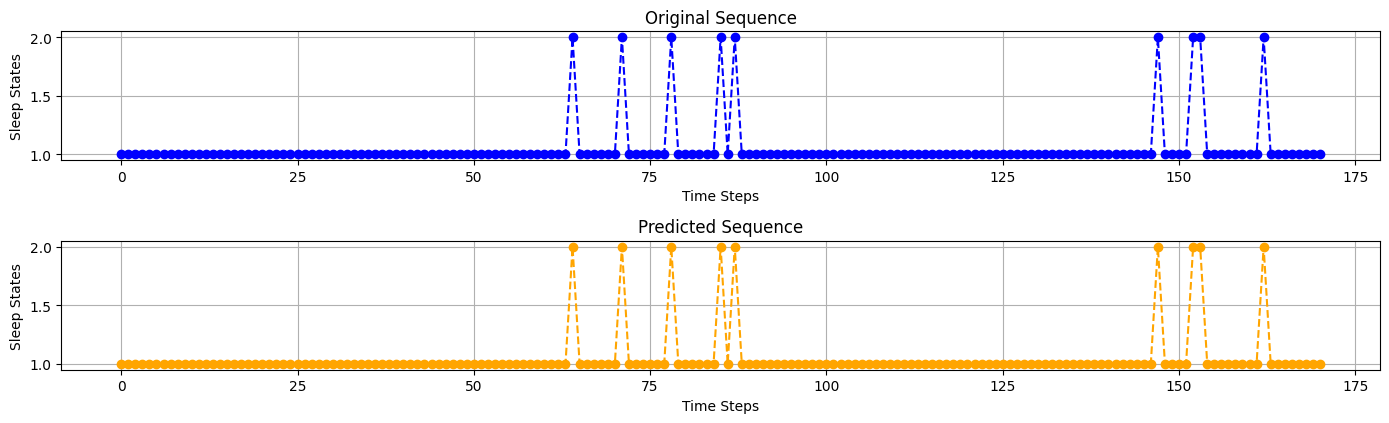

In [ ]:
# HMM Week 5 (has some impotant fearutres removed in week 6 version)
"""
Currently the original sequences are phasic & tonic data.
That's why n_states=2 and the smoothing part is put on comment in the code.
Remember to adjust the number of iterations in TRAINING part of the code.
"""

#!pip install hmmlearn #put line on comment after first run

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# ORIGINAL SEQUENCES -----------------------------------------------------------

# CBD ctrl (csv line 1)
# has 100% accuracy with 44 iterations
#original_sequence=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

# CBD tre (csv line 144)
# has 100% accuracy with 50 iterations
#original_sequence = [1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# RGS tre (csv line 560)
# has 100% accuracy with 8 iterations
original_sequence=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,2,1,1,1,1,1,1,2,1,1,1,1,1,1,2,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,2,2,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1]

# RGS ctrl (csv line 649)
# has 100% accuracy with 1 iteration
#original_sequence=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

#-------------------------------------------------------------------------------

original_sequence = np.array(original_sequence)
n_states = 2  # HERE change the number of states to suit original_sequence

# TRANSITION MATRIX
transition_matrix = np.zeros((n_states, n_states))
for (current_state, next_state) in zip(original_sequence[:-1], original_sequence[1:]):
    transition_matrix[current_state - 1, next_state - 1] += 1
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

# EMISSION MATRIX (slightly noisy diagonal)
emission_matrix = np.eye(n_states) * 0.9 + 0.1 / n_states

# Convert observed sequence to 0-based indexing & set up observed counts for HMM (one-hot encoded observations)
observed_sequence = (original_sequence - 1).reshape(-1, 1)
observed_counts = np.zeros((observed_sequence.shape[0], n_states), dtype=int)
for i in range(observed_sequence.shape[0]):
    observed_counts[i, observed_sequence[i, 0]] = 1

# HMM MODEL
model = hmm.MultinomialHMM(n_components=n_states, n_iter=1, tol=0.01, random_state=42, init_params='')
start_state = original_sequence[0] - 1
model.startprob_ = np.zeros(n_states)
model.startprob_[start_state] = 1
model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix

# TRAINING ---------------------------------------------------------------------
#iterations = 1 #HERE change the number of iterations to train the model
iterations = int(input("iterations: "))
for _ in range(iterations):
    model.fit(observed_counts)
#-------------------------------------------------------------------------------

# PREDICTED SEQUENCE
predicted_sequence = model.predict(observed_counts)
predicted_sequence = predicted_sequence + 1

# SMOOTHING
def smooth_sequence(sequence):
    smoothed_sequence = []
    i = 0
    while i < len(sequence):
        count = 1
        while (i + 1 < len(sequence)) and (sequence[i] == sequence[i + 1]):
            count += 1
            i += 1
        if count > 1:
            smoothed_sequence.extend([sequence[i]] * count)
        else:
            if smoothed_sequence:
                smoothed_sequence.extend([smoothed_sequence[-1]] * count)
            else:
                smoothed_sequence.extend([sequence[i]] * count)
        i += 1
    return np.array(smoothed_sequence)

smoothed_sequence = smooth_sequence(predicted_sequence)

# REDUCTION
reduced_sequence = [smoothed_sequence[0]]
for i in range(1, len(smoothed_sequence)):
    if smoothed_sequence[i] != smoothed_sequence[i - 1]:
        reduced_sequence.append(smoothed_sequence[i])

reduced_sequence2 = [predicted_sequence[0]]
for i in range(1, len(predicted_sequence)):
    if predicted_sequence[i] != predicted_sequence[i - 1]:
        reduced_sequence2.append(predicted_sequence[i])

# NUMBER OF TRANSITIONS --------------------------------------------------------
transitions = 0
for i in range(1, len(original_sequence)):
    if original_sequence[i] != original_sequence[i - 1]:
        transitions += 1

# ACCURACY (%) & PROBABILITIES -------------------------------------------------
accuracy = accuracy_score(original_sequence, predicted_sequence)
accuracy2 = accuracy_score(original_sequence, smoothed_sequence)
print("")
print(f"Original Sequence: {original_sequence}")
print(f"Predicted Sequence: {predicted_sequence}")
print("")
#print(f"Smoothed Sequence: {smoothed_sequence}")
#print("Reduced Sequence:", reduced_sequence)
print(f"Original sequence length: {len(original_sequence)}")
#print(f"Smoothed sequence length: {len(smoothed_sequence)}")
#print(f"Latent States (original): {len(reduced_sequence2)}")
#print(f"Latent States (smoothed): {len(reduced_sequence)}")
print(f"Accuracy (predicted sequence): {accuracy * 100:.2f}%")
#print(f"Accuracy (smoothed sequence): {accuracy2 * 100:.2f}%")
print(f"Training iterations = {iterations}")

p_Tonic_to_Tonic = transition_matrix[0, 0]
p_Tonic_to_Phase = transition_matrix[0, 1]
p_Phase_to_Tonic = transition_matrix[1, 0]
p_Phase_to_Phase = transition_matrix[1, 1]
print("")
print("TRANSITION PROBABILITIES:")
print(f"Staying in Tonic (1 → 1): {p_Tonic_to_Tonic:.4f}")
print(f"Tonic to Phasic (1 → 2): {p_Tonic_to_Phase:.4f}")
print(f"Phasic to Tonic (2 → 1): {p_Phase_to_Tonic:.4f}")
print(f"Staying in Phasic (2 → 2): {p_Phase_to_Phase:.4f}")
print(f"Number of transitions between states: {transitions}")

# FIGURES ----------------------------------------------------------------------
plt.figure(figsize=(14, 6))

plt.subplot(3, 1, 1)
plt.plot(original_sequence, color='blue', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(predicted_sequence, color='orange', marker='o', linestyle='dashed')
plt.title("Predicted Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)

"""
plt.subplot(3, 1, 3)
plt.plot(smoothed_sequence, color='red', marker='o', linestyle='dashed')
plt.title("Smoothed Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)
"""

plt.tight_layout()
plt.show()



https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Original Sequence: [3 2 2 5 5 5 5 4 4 4 4 1 4 4 4 4 4 1 2 2 2 2 2 2 2 2 2 2 4 4 1 3 3 3 3 3 5
 5 5 2 2 4 4 4 4 5 5 5 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 2
 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 3 3
 3 3 3 3 5 5 5 2 2 2 2 2 2 1 1 1 1 4 5 5 5 5 5 3 3 3 3 3 3 3 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 3 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 2 2 1 1 1 1 3 3 3 3 3 3 3
 3 3 3 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4
 2 2 2 2 2 2 2 2 2 1 5 5 5 5 5 5 5 5 5 5 3 3 3 3 3 1 1 1 1 1 1 2 2 2 2 2 4
 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 5 3 3 3 3 3 3 3 1 1 1 5 2 2 2 2 2 2 2 2
 2 4 4 5 5 5 5 5 5 5 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 2 2 2 4 4 4 4 4
 4 4 4 4 4 2 2 2 2 1 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 3 3 3 3 1 3 3 3 3 3 3 3
 4 4 4 4 2 2 2 2 2 5 5 5 5 5 3 3 3 3 3 1 1 1 1 1 1 1 1 4 4 4]
Predicted Sequence: [3 2 2 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 4 4 4 3 3 3 3 3 5
 5 5 2 2 4 4 4 4 5 5 5 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 2

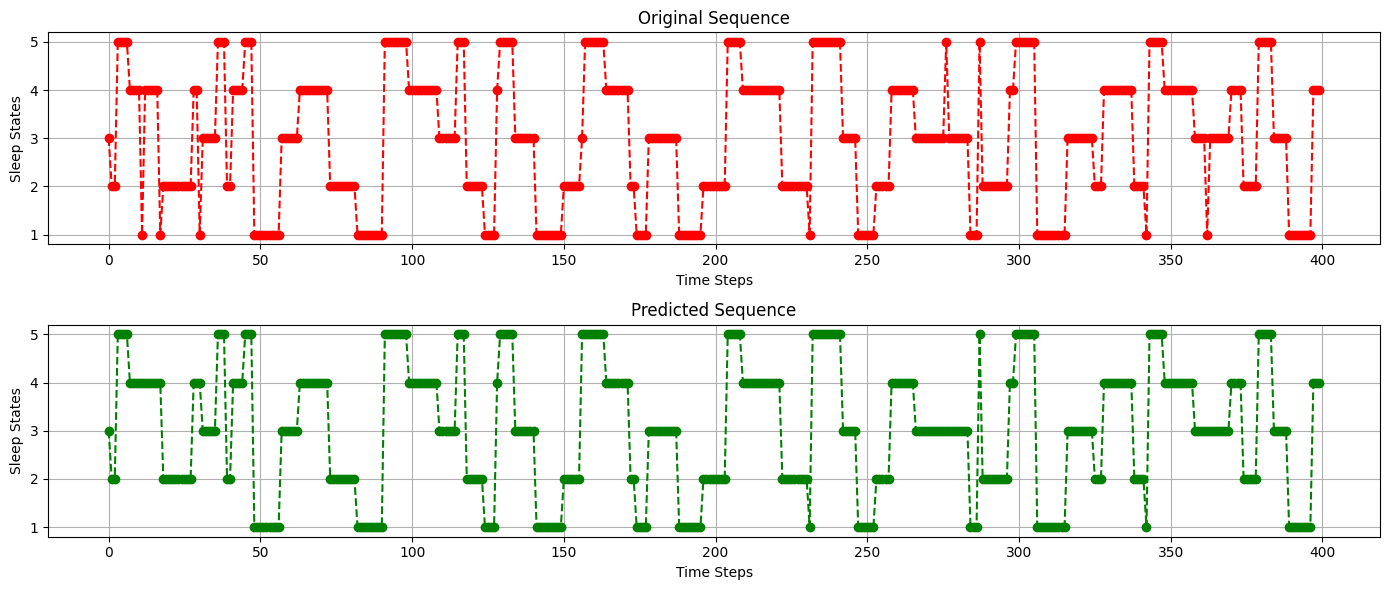

In [ ]:
# @title HMM V1
# this is the best one so far

# install hmmlearn first time running on colab : (line below)
# !pip install hmmlearn

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

original_sequence = [3, 2, 2, 5, 5, 5, 5, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 1, 3, 3, 3, 3, 3, 5, 5, 5, 2, 2, 4, 4, 4, 4, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 5, 5, 5, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 4, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 1, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4]


original_sequence = np.array(original_sequence)
n_states = 5  # hidden states

# TRANSITION MATRIX
transition_matrix = np.zeros((n_states, n_states))
for (current_state, next_state) in zip(original_sequence[:-1], original_sequence[1:]):
    transition_matrix[current_state - 1, next_state - 1] += 1
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)  # normalize row-wise

# EMISSION MATRIX (slightly noisy diagonal)
emission_matrix = np.eye(n_states) * 0.9 + 0.1 / n_states

# Convert observed sequence to 0-based indexing & set up observed counts for HMM (one-hot encoded observations)
observed_sequence = (original_sequence - 1).reshape(-1, 1)
observed_counts = np.zeros((observed_sequence.shape[0], n_states), dtype=int)
for i in range(observed_sequence.shape[0]):
    observed_counts[i, observed_sequence[i, 0]] = 1

# HMM MODEL
model = hmm.MultinomialHMM(n_components=n_states, n_iter=1, tol=0.01, random_state=42, init_params='')
start_state = original_sequence[0] - 1  # convert to 0-based index
model.startprob_ = np.zeros(n_states)
model.startprob_[start_state] = 1  # start with the same state as original sequence
model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix

# TRAINING
iterations = 100
for _ in range(iterations):
    model.fit(observed_counts)


# PREDICTED SEQUENCE
predicted_sequence = model.predict(observed_counts)
predicted_sequence = predicted_sequence + 1  # adjust back to 1-based indexing


# REDUCTION OF LATENT STATES
reduced_sequence = [predicted_sequence[0]]
for i in range(1, len(predicted_sequence)):
    if predicted_sequence[i] != predicted_sequence[i - 1]:
        reduced_sequence.append(predicted_sequence[i])

# ACCURACY (%)
accuracy = accuracy_score(original_sequence, predicted_sequence)
print(f"Original Sequence: {original_sequence}")
print(f"Predicted Sequence: {predicted_sequence}")
print("Reduced Sequence:", reduced_sequence)
print(f"Original sequence length: {len(original_sequence)}")
print(f"Reduced sequence length: {len(reduced_sequence)}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# FIGURES
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(original_sequence, color='red', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(predicted_sequence, color='green', marker='o', linestyle='dashed')
plt.title("Predicted Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)

plt.tight_layout()
plt.show()


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Original Sequence: [1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2 3 3 3 3 4 4 4 5 5 5 1 1 2 2 3 3 4 4
 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 1 1 1 2 2 2 3 3 4 4 5 5 5 5 1 1
 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2 3 3 3 3 4 4 4 5 5 5 1 1
 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 1 1 1 2 2 2 3 3 4 4
 5 5 5 5 1 1 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2 3 3 3 3 4 4
 4 5 5 5 1 1 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 1 1 1 2
 2 2 3 3 4 4 5 5 5 5 1 1 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2
 3 3 3 3 4 4 4 5 5 5 1 1 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5
 5 5 1 1 1 2 2 2 3 3 4 4 5 5 5 5 1 1 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5
 1 1 1 1 2 2 3 3 3 3 4 4 4 5 5 5 1 1 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3
 4 4 4 4 5 5 5 5 1 1 1 2 2 2 3 3 4 4 5 5 5 5 1 1 2 2 3 4 4 5]
Predicted Sequence: [1 2 2 3 3 3 3 3 3 4 4 5 5 1 2 2 2 3 3 3 3 3 3 4 4 4 5 5 5 1 2 3 3 3 3 4 4
 5 1 2 2 2 2 3 3 3 3 3 3 3 4 4 4 4 5 5 5 5 1 2 2 3 3 3 3 3 4 4 5 5 5 5 1 2

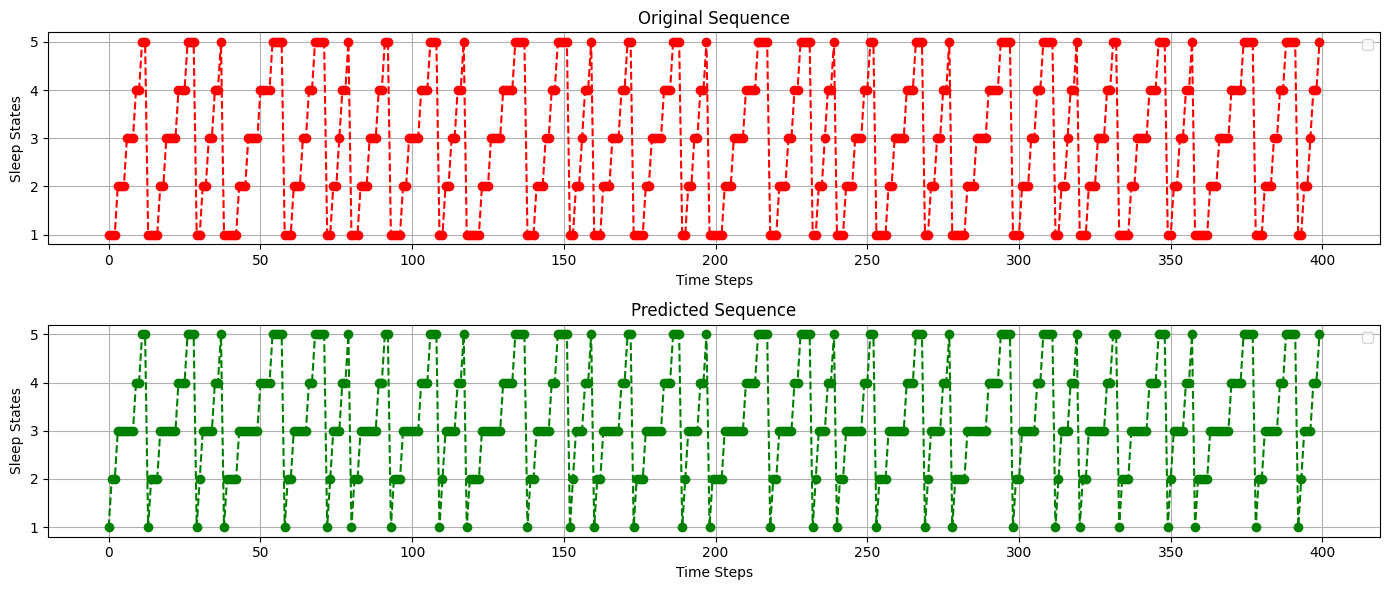

In [ ]:
# @title [old] 5

# This program uses a random sequence

# install hmmlearn first time running on colab : (line below)
!pip install hmmlearn

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

original_sequence = [
    1, 1, 1, 2, 2, 2, 3, 3, 3, 4,
    4, 5, 5, 1, 1, 1, 1, 2, 2, 3,
    3, 3, 3, 4, 4, 4, 5, 5, 5, 1,
    1, 2, 2, 3, 3, 4, 4, 5, 1, 1,
    1, 1, 1, 2, 2, 2, 3, 3, 3, 3,
    4, 4, 4, 4, 5, 5, 5, 5, 1, 1,
    1, 2, 2, 2, 3, 3, 4, 4, 5, 5,
    5, 5, 1, 1, 2, 2, 3, 4, 4, 5] * 5  # 400 numbers in total following a certain pattern

original_sequence = np.array(original_sequence)

#Transition matrix
n_states = 5
transition_matrix = np.zeros((n_states, n_states))

for (current_state, next_state) in zip(original_sequence[:-1], original_sequence[1:]):
    transition_matrix[current_state - 1, next_state - 1] += 1

transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)  # Normalize transition matrix

#Emission matrix
emission_matrix = np.eye(n_states)

#HMM
observed_sequence = (original_sequence - 1).reshape(-1, 1)  # convert to 0-based indexing

n_trials = np.ones(observed_sequence.shape[0])  # each observation is a single trial

observed_counts = np.zeros((observed_sequence.shape[0], n_states), dtype=int)  # create observed counts for HMM

for i in range(observed_sequence.shape[0]):
    observed_counts[i, observed_sequence[i, 0]] = 1  # Set the count for the observed value

#Initialize the HMM model
model = hmm.MultinomialHMM(n_components=n_states, n_iter=100, tol=0.01, random_state=42)
start_state = original_sequence[0] - 1  # Convert to 0-based index
model.startprob_ = np.zeros(n_states)
model.startprob_[start_state] = 1  # Set 100% start probability at the initial state of the original sequence

model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix
model.n_trials = n_trials

#Fit the model to the observed counts
model.fit(observed_counts)

#Predict the sequence
predicted_sequence = model.predict(observed_counts)
predicted_sequence = predicted_sequence + 1  # Adjust back to 1-based indexing

#Accuracy
accuracy = accuracy_score(original_sequence, predicted_sequence)
print(f"Original Sequence: {original_sequence}")
print(f"Predicted Sequence: {predicted_sequence}")
print(f"Accuracy: {accuracy * 100:.2f}%")

#figures
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(original_sequence, color='red', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(predicted_sequence, color='green', marker='o', linestyle='dashed')
plt.title("Predicted Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Original Sequence: [1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2 3 3 3 3 4 4 4 5 5 5 1 1 2 2 3 3 4 4
 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 1 1 1 2 2 2 3 3 4 4 5 5 5 5 1 1
 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2 3 3 3 3 4 4 4 5 5 5 1 1
 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 1 1 1 2 2 2 3 3 4 4
 5 5 5 5 1 1 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2 3 3 3 3 4 4
 4 5 5 5 1 1 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 1 1 1 2
 2 2 3 3 4 4 5 5 5 5 1 1 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2
 3 3 3 3 4 4 4 5 5 5 1 1 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5
 5 5 1 1 1 2 2 2 3 3 4 4 5 5 5 5 1 1 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5
 1 1 1 1 2 2 3 3 3 3 4 4 4 5 5 5 1 1 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3
 4 4 4 4 5 5 5 5 1 1 1 2 2 2 3 3 4 4 5 5 5 5 1 1 2 2 3 4 4 5]
Predicted Sequence: [4 5 3 3 3 3 3 3 3 4 4 2 2 2 2 1 5 3 3 3 3 3 3 4 4 4 2 2 2 1 5 3 3 3 3 4 4
 2 2 2 2 1 5 3 3 3 3 3 3 3 4 4 4 4 2 2 2 2 2 1 5 3 3 3 3 3 4 4 2 2 2 2 1 5

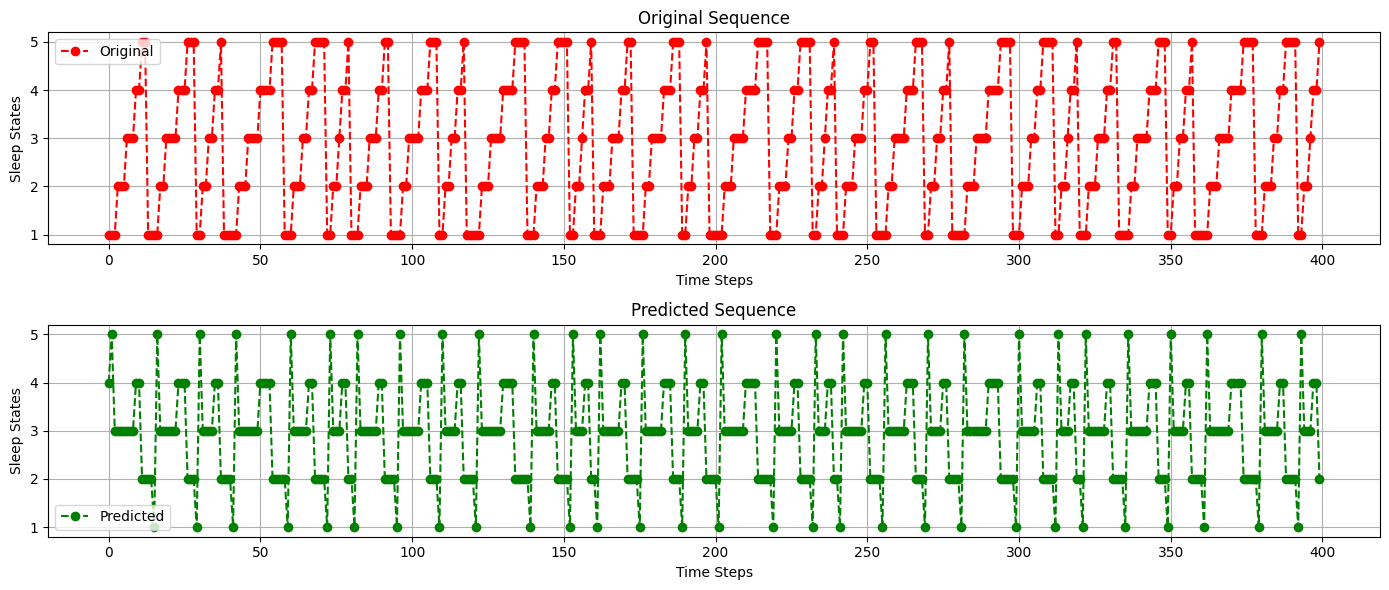

In [ ]:
# @title [old] 6

# This program uses a random sequence

# install hmmlearn first time running on colab : (line below)

!pip install hmmlearn

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Original sequence with a repeating pattern
original_sequence = [
    1, 1, 1, 2, 2, 2, 3, 3, 3, 4,
    4, 5, 5, 1, 1, 1, 1, 2, 2, 3,
    3, 3, 3, 4, 4, 4, 5, 5, 5, 1,
    1, 2, 2, 3, 3, 4, 4, 5, 1, 1,
    1, 1, 1, 2, 2, 2, 3, 3, 3, 3,
    4, 4, 4, 4, 5, 5, 5, 5, 1, 1,
    1, 2, 2, 2, 3, 3, 4, 4, 5, 5,
    5, 5, 1, 1, 2, 2, 3, 4, 4, 5] * 5  # 400 numbers in total following a certain pattern

original_sequence = np.array(original_sequence)

n_states = 5

# HMM - Preprocessing the observed sequence
observed_sequence = (original_sequence - 1).reshape(-1, 1)  # Convert to 0-based indexing

n_trials = np.ones(observed_sequence.shape[0])  # Each observation is a single trial

# Create observed counts for the HMM
observed_counts = np.zeros((observed_sequence.shape[0], n_states), dtype=int)

for i in range(observed_sequence.shape[0]):
    observed_counts[i, observed_sequence[i, 0]] = 1  # Set the count for the observed value

# Initialize the HMM model
model = hmm.MultinomialHMM(n_components=n_states, n_iter=1, tol=0.01, random_state=42)

# Number of iterations to refine the model
iterations = 5

# Train the model iteratively
for _ in range(iterations):
    model.fit(observed_counts)

# Predict the sequence using the trained model
predicted_sequence = model.predict(observed_counts)
predicted_sequence = predicted_sequence + 1  # Adjust back to 1-based indexing

# Calculate accuracy
accuracy = accuracy_score(original_sequence, predicted_sequence)
print(f"Original Sequence: {original_sequence}")
print(f"Predicted Sequence: {predicted_sequence}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plotting the results
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(original_sequence, color='red', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)
plt.legend(['Original'])

plt.subplot(2, 1, 2)
plt.plot(predicted_sequence, color='green', marker='o', linestyle='dashed')
plt.title("Predicted Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)
plt.legend(['Predicted'])

plt.tight_layout()
plt.show()


# **Creating a random sequence :**

In [ ]:
import numpy as np

sequence = []

while len(sequence) < 400:
    numbers = np.random.permutation([1, 2, 3, 4, 5])
    for number in numbers:
        repetition = np.random.randint(1, 11)
        sequence.extend([number] * repetition)
    if len(sequence) >= 400:
        sequence = sequence[:400]
        break

print("Sequence of 400 numbers randomly picked from 1 to 5, repeating 1 to 10 times:")
print(sequence)

Sequence of 400 numbers randomly picked from 1 to 5, repeating 1 to 10 times:
[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 4, 4, 3, 3, 3, 3, 3, 1, 1, 4, 4, 4, 4, 4, 4, 5, 5, 5, 2, 2, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 5, 5, 5, 5, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 2, 3, 3, 3, 

# **[other] Extracting a dataset**

In [ ]:
#@title [other] dataset_extraction.py
import h5py
import numpy as np
import random

def training_dataset_OS_RGS_CBD(file_path, n_states, n_repeat_states, rat_indices_OS, rat_indices_RGS, rat_indices_CBD):
    """
    Extract a training dataset from the OS_RGS_CBD.h5 file.

    Parameters :
    file_path (str): the file_path to the OS_RGS_CBD.h5 file
    n_states (int array): an array of 5 integers : [n_artefact, n_wake, n_nrem, n_TS, n_rem]. Each integer corresponds to the number of wanted epochs for the given state.
    n_repeat_states (int array): an array of 5 integers : [n_repeat_artefact, n_repeat_wake, n_repeat_nrem, n_repeat_TS, n_repeat_rem].
                      Each integer corresponds to the number of times the epochs of the given state will be repeated in the training dataset.
    rat_indices_OS (int array): the indices of the rats from the OS_Basic dataset that would be included in the training dataset. #Included in [1, 3, 4, 6, 9, 11, 13]
    rat_indices_RGS (int array): the indices of the rats from the RGS14 dataset that would be included in the training dataset. #Included in [1, 2, 3, 4, 6, 7, 8, 9] (RGS control : [1, 2, 6, 9] and RGS positive : [3, 4, 7, 8])
    rat_indices_CBD (int array): the indices of the rats from the CBD dataset that would be included in the training dataset. #Included in [3, 4, 5, 6]

    Returns :
    float numpy.array : an array containing the features for each epoch of the training dataset.
    int numpy.array : an array containing the manual sleep state scoring of each epoch of the training dataset.
    """
    n_artefact, n_wake, n_nrem, n_TS, n_rem = n_states
    n_repeat_artefact, n_repeat_wake, n_repeat_nrem, n_repeat_TS, n_repeat_rem = n_repeat_states
    training_dataset = np.empty((0, 10))
    manual_scoring = np.array([])

    array_scores_total = np.array([])
    array_features_total = np.empty((0, 10))
    indices_artefact_total = np.array([])
    indices_wake_total = np.array([])
    indices_nrem_total = np.array([])
    indices_TS_total = np.array([])
    indices_rem_total = np.array([])
    with h5py.File(file_path, 'r') as hdf:
      for i in rat_indices_OS:
        array_scores = np.array([])
        array_features = np.empty((0, 10))
        for group_name in hdf["OS_basic"][f"Rat{i}"]:
            group = hdf["OS_basic"][f"Rat{i}"][group_name]
            array_scores = np.concatenate((array_scores, group['Mapped_scores'][:]), axis = 0)
            array_features = np.concatenate((array_features, group['Features'][:]), axis = 0)
        indices_artefact = np.where(array_scores == 0)[0] # Artefact
        indices_wake = np.where(array_scores == 1)[0] # Wake
        indices_nrem = np.where(array_scores == 3)[0] # NREM
        indices_TS = np.where(array_scores  == 4)[0] #TS
        indices_rem = np.where(array_scores == 5)[0] # REM
        len_scores = len(array_scores_total)

        array_scores_total = np.concatenate((array_scores_total, array_scores), axis = 0)
        array_features_total = np.concatenate((array_features_total, array_features), axis = 0)
        indices_artefact = np.array([el + len_scores for el in indices_artefact])
        indices_wake = np.array([el + len_scores for el in indices_wake])
        indices_nrem = np.array([el + len_scores for el in indices_nrem])
        indices_TS = np.array([el + len_scores for el in indices_TS])
        indices_rem = np.array([el + len_scores for el in indices_rem])
        indices_artefact_total = np.concatenate((indices_artefact_total, indices_artefact), axis = 0)
        indices_wake_total = np.concatenate((indices_wake_total, indices_wake), axis = 0)
        indices_nrem_total = np.concatenate((indices_nrem_total, indices_nrem), axis = 0)
        indices_TS_total = np.concatenate((indices_TS_total, indices_TS), axis = 0)
        indices_rem_total = np.concatenate((indices_rem_total, indices_rem), axis = 0)

      for i in rat_indices_RGS:
        array_scores = np.array([])
        array_features = np.empty((0, 10))
        for group_name in hdf["RGS14"][f"Rat{i}"]:
            group = hdf["RGS14"][f"Rat{i}"][group_name]
            array_scores = np.concatenate((array_scores, group['Mapped_scores'][:]), axis = 0)
            array_features = np.concatenate((array_features, group['Features'][:]), axis = 0)
        indices_artefact = np.where(array_scores == 0)[0] # Artefact
        indices_wake = np.where(array_scores == 1)[0] # Wake
        indices_nrem = np.where(array_scores == 3)[0] # NREM
        indices_TS = np.where(array_scores  == 4)[0] #TS
        indices_rem = np.where(array_scores == 5)[0] # REM
        len_scores = len(array_scores_total)

        array_scores_total = np.concatenate((array_scores_total, array_scores), axis = 0)
        array_features_total = np.concatenate((array_features_total, array_features), axis = 0)
        indices_artefact = np.array([el + len_scores for el in indices_artefact])
        indices_wake = np.array([el + len_scores for el in indices_wake])
        indices_nrem = np.array([el + len_scores for el in indices_nrem])
        indices_TS = np.array([el + len_scores for el in indices_TS])
        indices_rem = np.array([el + len_scores for el in indices_rem])
        indices_artefact_total = np.concatenate((indices_artefact_total, indices_artefact), axis = 0)
        indices_wake_total = np.concatenate((indices_wake_total, indices_wake), axis = 0)
        indices_nrem_total = np.concatenate((indices_nrem_total, indices_nrem), axis = 0)
        indices_TS_total = np.concatenate((indices_TS_total, indices_TS), axis = 0)
        indices_rem_total = np.concatenate((indices_rem_total, indices_rem), axis = 0)
      for i in rat_indices_CBD:
        array_scores = np.array([])
        array_features = np.empty((0, 10))
        for group_name in hdf["CBD"][f"Rat{i}"]:
            group = hdf["CBD"][f"Rat{i}"][group_name]
            array_scores = np.concatenate((array_scores, group['Mapped_scores'][:]), axis = 0)
            array_features = np.concatenate((array_features, group['Features'][:]), axis = 0)
        indices_artefact = np.where(array_scores == 0)[0] # Artefact
        indices_wake = np.where(array_scores == 1)[0] # Wake
        indices_nrem = np.where(array_scores == 3)[0] # NREM
        indices_TS = np.where(array_scores  == 4)[0] #TS
        indices_rem = np.where(array_scores == 5)[0] # REM
        len_scores = len(array_scores_total)
        array_scores_total = np.concatenate((array_scores_total, array_scores), axis = 0)
        array_features_total = np.concatenate((array_features_total, array_features), axis = 0)
        indices_artefact = np.array([el + len_scores for el in indices_artefact])
        indices_wake = np.array([el + len_scores for el in indices_wake])
        indices_nrem = np.array([el + len_scores for el in indices_nrem])
        indices_TS = np.array([el + len_scores for el in indices_TS])
        indices_rem = np.array([el + len_scores for el in indices_rem])
        indices_artefact_total = np.concatenate((indices_artefact_total, indices_artefact), axis = 0)
        indices_wake_total = np.concatenate((indices_wake_total, indices_wake), axis = 0)
        indices_nrem_total = np.concatenate((indices_nrem_total, indices_nrem), axis = 0)
        indices_TS_total = np.concatenate((indices_TS_total, indices_TS), axis = 0)
        indices_rem_total = np.concatenate((indices_rem_total, indices_rem), axis = 0)

    selected_indices_artefact = random.sample(list(indices_artefact_total), n_artefact)
    selected_indices_wake = random.sample(list(indices_wake_total), n_wake)
    selected_indices_nrem = random.sample(list(indices_nrem_total), n_nrem)
    selected_indices_TS = random.sample(list(indices_TS_total), n_TS)
    selected_indices_rem = random.sample(list(indices_rem_total), n_rem)
    selected_indices_artefact = np.ravel([[el]* n_repeat_artefact for el in selected_indices_artefact])
    selected_indices_wake = np.ravel([[el]* n_repeat_wake for el in selected_indices_wake])
    selected_indices_nrem = np.ravel([[el]* n_repeat_nrem for el in selected_indices_nrem])
    selected_indices_TS = np.ravel([[el]* n_repeat_TS for el in selected_indices_TS])
    selected_indices_rem = np.ravel([[el]* n_repeat_rem for el in selected_indices_rem])

    features_artefact = array_features_total[selected_indices_artefact.astype(int)]
    scores = array_scores_total[selected_indices_artefact.astype(int)]
    training_dataset = np.concatenate((training_dataset, features_artefact), axis=0)
    manual_scoring = np.concatenate((manual_scoring, scores), axis=0)

    features_wake = array_features_total[selected_indices_wake.astype(int)]
    scores = array_scores_total[selected_indices_wake.astype(int)]
    training_dataset = np.concatenate((training_dataset, features_wake), axis=0)          # Filling up training dataset
    manual_scoring = np.concatenate((manual_scoring, scores), axis=0)                     # Filling up corresponding manual scores

    features_nrem = array_features_total[selected_indices_nrem.astype(int)]
    scores = array_scores_total[selected_indices_nrem.astype(int)]
    training_dataset = np.concatenate((training_dataset, features_nrem), axis=0)
    manual_scoring = np.concatenate((manual_scoring, scores), axis=0)

    features_TS = array_features_total[selected_indices_TS.astype(int)]
    scores = array_scores_total[selected_indices_TS.astype(int)]
    training_dataset = np.concatenate((training_dataset, features_TS), axis=0)
    manual_scoring = np.concatenate((manual_scoring, scores), axis=0)

    features_rem = array_features_total[selected_indices_rem.astype(int)]
    scores = array_scores_total[selected_indices_rem.astype(int)]
    training_dataset = np.concatenate((training_dataset, features_rem), axis=0)
    manual_scoring = np.concatenate((manual_scoring, scores), axis=0)

    paired = list(zip(training_dataset, manual_scoring))

    # Shuffle the paired list
    random.shuffle(paired)

    # Unzip the shuffled, paired list back into features and scores
    training_dataset, manual_scoring = zip(*paired)
    # training_dataset = np.array()
    training_dataset = np.array(training_dataset)
    manual_scoring = np.array(manual_scoring)

    return training_dataset, manual_scoring.astype(int)

def dataset_OS_RGS_CBD(file_path, rat_indices_OS, rat_indices_RGS, rat_indices_CBD, states):
    """
    Extract a dataset from the OS_RGS_CBD.h5 file.

    Parameters :
    file_path (str): the file_path to the OS_RGS_CBD.h5 file
    rat_indices_OS (int array): the indices of the rats from the OS_Basic dataset that would be included in the training dataset. #Included in [1, 3, 4, 6, 9, 11, 13]
    rat_indices_RGS (int array): the indices of the rats from the RGS14 dataset that would be included in the training dataset. #Included in [1, 2, 3, 4, 6, 7, 8, 9] (RGS control : [1, 2, 6, 9] and RGS positive : [3, 4, 7, 8])
    rat_indices_CBD (int array): the indices of the rats from the CBD dataset that would be included in the training dataset. #Included in [3, 4, 5, 6]
    states : (str array) : an array containing the names of the states wanted in the dataset #Included in  ["artefact", "Wake", "NREM", "TS", "REM]

    Returns :
    float numpy.array : an array containing the features for each epoch of the dataset.
    int numpy.array : an array containing the manual sleep state scoring of each epoch of the dataset.

    Notes:
    The dataset obtained is not in a chronological order.
    """
    dataset = np.empty((0, 10))
    manual_scoring = np.array([])

    array_scores_total = np.array([])
    array_features_total = np.empty((0, 10))
    indices_artefact_total = np.array([])
    indices_wake_total = np.array([])
    indices_nrem_total = np.array([])
    indices_TS_total = np.array([])
    indices_rem_total = np.array([])
    with h5py.File(file_path, 'r') as hdf:
      for i in rat_indices_OS:
        array_scores = np.array([])
        array_features = np.empty((0, 10))
        for group_name in hdf["OS_basic"][f"Rat{i}"]:
            group = hdf["OS_basic"][f"Rat{i}"][group_name]
            array_scores = np.concatenate((array_scores, group['Mapped_scores'][:]), axis = 0)
            array_features = np.concatenate((array_features, group['Features'][:]), axis = 0)
        indices_artefact = np.where(array_scores == 0)[0] # Artefact
        indices_wake = np.where(array_scores == 1)[0] # Wake
        indices_nrem = np.where(array_scores == 3)[0] # NREM
        indices_TS = np.where(array_scores  == 4)[0] #TS
        indices_rem = np.where(array_scores == 5)[0] # REM
        len_scores = len(array_scores_total)

        array_scores_total = np.concatenate((array_scores_total, array_scores), axis = 0)
        array_features_total = np.concatenate((array_features_total, array_features), axis = 0)
        indices_artefact = np.array([el + len_scores for el in indices_artefact])
        indices_wake = np.array([el + len_scores for el in indices_wake])
        indices_nrem = np.array([el + len_scores for el in indices_nrem])
        indices_TS = np.array([el + len_scores for el in indices_TS])
        indices_rem = np.array([el + len_scores for el in indices_rem])
        indices_artefact_total = np.concatenate((indices_artefact_total, indices_artefact), axis = 0)
        indices_wake_total = np.concatenate((indices_wake_total, indices_wake), axis = 0)
        indices_nrem_total = np.concatenate((indices_nrem_total, indices_nrem), axis = 0)
        indices_TS_total = np.concatenate((indices_TS_total, indices_TS), axis = 0)
        indices_rem_total = np.concatenate((indices_rem_total, indices_rem), axis = 0)

      for i in rat_indices_RGS:
        array_scores = np.array([])
        array_features = np.empty((0, 10))
        for group_name in hdf["RGS14"][f"Rat{i}"]:
            group = hdf["RGS14"][f"Rat{i}"][group_name]
            array_scores = np.concatenate((array_scores, group['Mapped_scores'][:]), axis = 0)
            array_features = np.concatenate((array_features, group['Features'][:]), axis = 0)
        indices_artefact = np.where(array_scores == 0)[0] # Artefact
        indices_wake = np.where(array_scores == 1)[0] # Wake
        indices_nrem = np.where(array_scores == 3)[0] # NREM
        indices_TS = np.where(array_scores  == 4)[0] #TS
        indices_rem = np.where(array_scores == 5)[0] # REM
        len_scores = len(array_scores_total)

        array_scores_total = np.concatenate((array_scores_total, array_scores), axis = 0)
        array_features_total = np.concatenate((array_features_total, array_features), axis = 0)
        indices_artefact = np.array([el + len_scores for el in indices_artefact])
        indices_wake = np.array([el + len_scores for el in indices_wake])
        indices_nrem = np.array([el + len_scores for el in indices_nrem])
        indices_TS = np.array([el + len_scores for el in indices_TS])
        indices_rem = np.array([el + len_scores for el in indices_rem])
        indices_artefact_total = np.concatenate((indices_artefact_total, indices_artefact), axis = 0)
        indices_wake_total = np.concatenate((indices_wake_total, indices_wake), axis = 0)
        indices_nrem_total = np.concatenate((indices_nrem_total, indices_nrem), axis = 0)
        indices_TS_total = np.concatenate((indices_TS_total, indices_TS), axis = 0)
        indices_rem_total = np.concatenate((indices_rem_total, indices_rem), axis = 0)

      for i in rat_indices_CBD:
        array_scores = np.array([])
        array_features = np.empty((0, 10))
        for group_name in hdf["CBD"][f"Rat{i}"]:
            group = hdf["CBD"][f"Rat{i}"][group_name]
            array_scores = np.concatenate((array_scores, group['Mapped_scores'][:]), axis = 0)
            array_features = np.concatenate((array_features, group['Features'][:]), axis = 0)
        indices_artefact = np.where(array_scores == 0)[0] # Artefact
        indices_wake = np.where(array_scores == 1)[0] # Wake
        indices_nrem = np.where(array_scores == 3)[0] # NREM
        indices_TS = np.where(array_scores  == 4)[0] #TS
        indices_rem = np.where(array_scores == 5)[0] # REM
        len_scores = len(array_scores_total)
        array_scores_total = np.concatenate((array_scores_total, array_scores), axis = 0)
        array_features_total = np.concatenate((array_features_total, array_features), axis = 0)
        indices_artefact = np.array([el + len_scores for el in indices_artefact])
        indices_wake = np.array([el + len_scores for el in indices_wake])
        indices_nrem = np.array([el + len_scores for el in indices_nrem])
        indices_TS = np.array([el + len_scores for el in indices_TS])
        indices_rem = np.array([el + len_scores for el in indices_rem])
        indices_artefact_total = np.concatenate((indices_artefact_total, indices_artefact), axis = 0)
        indices_wake_total = np.concatenate((indices_wake_total, indices_wake), axis = 0)
        indices_nrem_total = np.concatenate((indices_nrem_total, indices_nrem), axis = 0)
        indices_TS_total = np.concatenate((indices_TS_total, indices_TS), axis = 0)
        indices_rem_total = np.concatenate((indices_rem_total, indices_rem), axis = 0)

    states = [el.lower() for el in states]

    if "artefact" in states:
      features_artefact = array_features_total[indices_artefact_total.astype(int)]
      scores = array_scores_total[indices_artefact_total.astype(int)]
      dataset = np.concatenate((dataset, features_artefact), axis=0)
      manual_scoring = np.concatenate((manual_scoring, scores), axis=0)

    if "wake" in states:
      features_wake = array_features_total[indices_wake_total.astype(int)]
      scores = array_scores_total[indices_wake_total.astype(int)]
      dataset = np.concatenate((dataset, features_wake), axis=0)
      manual_scoring = np.concatenate((manual_scoring, scores), axis=0)

    if "nrem" in states:
      features_nrem = array_features_total[indices_nrem_total.astype(int)]
      scores = array_scores_total[indices_nrem_total.astype(int)]
      dataset = np.concatenate((dataset, features_nrem), axis=0)
      manual_scoring = np.concatenate((manual_scoring, scores), axis=0)

    if "ts" in states:
      features_TS = array_features_total[indices_TS_total.astype(int)]
      scores = array_scores_total[indices_TS_total.astype(int)]
      dataset = np.concatenate((dataset, features_TS), axis=0)
      manual_scoring = np.concatenate((manual_scoring, scores), axis=0)

    if "rem" in states:
      features_rem = array_features_total[indices_rem_total.astype(int)]
      scores = array_scores_total[indices_rem_total.astype(int)]
      dataset = np.concatenate((dataset, features_rem), axis=0)
      manual_scoring = np.concatenate((manual_scoring, scores), axis=0)

    dataset = np.array(dataset)
    manual_scoring = np.array(manual_scoring)

    return dataset, manual_scoring.astype(int)

def dataset_in_order_OS_RGS_CBD(file_path, rat_indexes_OS, rat_indexes_RGS, rat_indexes_CBD, states):
    """
    Extract a dataset from the OS_RGS_CBD.h5 file while keeping the epochs in a chronolical order for each posttrial.

    Parameters :
    file_path (str): the file_path to the OS_RGS_CBD.h5 file
    rat_indices_OS (int array): the indices of the rats from the OS_Basic dataset that would be included in the training dataset. #Included in [1, 3, 4, 6, 9, 11, 13]
    rat_indices_RGS (int array): the indices of the rats from the RGS14 dataset that would be included in the training dataset. #Included in [1, 2, 3, 4, 6, 7, 8, 9] (RGS control : [1, 2, 6, 9] and RGS positive : [3, 4, 7, 8])
    rat_indices_CBD (int array): the indices of the rats from the CBD dataset that would be included in the training dataset. #Included in [3, 4, 5, 6]
    states : (str array) : an array containing the names of the states wanted in the dataset #Included in  ["artefact", "Wake", "NREM", "TS", "REM]

    Returns :
    float numpy.array : an array containing the features for each epoch of the dataset.
    int numpy.array : an array containing the manual sleep state scoring of each epoch of the dataset.

    Notes:
    The dataset obtained is in a chronological order.
    If not all the states are included in the posttrial, this function will take a longer time than the dataset_OS_RGS_CBD function.
    """
    dataset = np.empty((0, 10))
    manual_scoring = np.array([])
    states = [el.lower() for el in states]
    int_states = []
    if "artefact" in states:
      int_states.append(0)
    if "wake" in states:
      int_states.append(1)
    if "nrem" in states:
      int_states.append(3)
    if "ts" in states:
      int_states.append(4)
    if "rem" in states:
      int_states.append(5)

    array_scores_total = np.array([])
    array_features_total = np.empty((0, 10))
    indices_artefact_total = np.array([])
    indices_wake_total = np.array([])
    indices_nrem_total = np.array([])
    indices_TS_total = np.array([])
    indices_rem_total = np.array([])
    with h5py.File(file_path, 'r') as hdf:
      for i in rat_indexes_OS:
        array_scores = np.array([])
        array_features = np.empty((0, 10))
        for group_name in hdf["OS_basic"][f"Rat{i}"]:
            group = hdf["OS_basic"][f"Rat{i}"][group_name]
            array_scores = group['Mapped_scores'][:]
            array_features = group['Features'][:]
            if int_states == [0, 1, 3, 4, 5]:
              array_features_total = np.concatenate((array_features_total, array_features), axis = 0)
              array_scores_total = np.concatenate((array_scores_total, array_scores), axis = 0)
            else:
              for j, el in enumerate(array_scores):
                  if el in int_states:
                    array_features_total = np.concatenate((array_features_total, [array_features[j]]), axis = 0)
                    array_scores_total = np.append(array_scores_total ,el)

      for i in rat_indexes_RGS:
        array_scores = np.array([])
        array_features = np.empty((0, 10))
        for group_name in hdf["RGS14"][f"Rat{i}"]:
            group = hdf["RGS14"][f"Rat{i}"][group_name]
            array_scores = group['Mapped_scores'][:]
            array_features = group['Features'][:]
            if int_states == [0, 1, 3, 4, 5]:
              array_features_total = np.concatenate((array_features_total, array_features), axis = 0)
              array_scores_total = np.concatenate((array_scores_total, array_scores), axis = 0)
            else:
              for j, el in enumerate(array_scores):
                  if el in int_states:
                    array_features_total = np.concatenate((array_features_total, [array_features[j]]), axis = 0)
                    array_scores_total = np.append(array_scores_total ,el)

      for i in rat_indexes_CBD:
        array_scores = np.array([])
        array_features = np.empty((0, 10))
        for group_name in hdf["CBD"][f"Rat{i}"]:
            group = hdf["CBD"][f"Rat{i}"][group_name]
            array_scores = group['Mapped_scores'][:]
            array_features = group['Features'][:]
            if int_states == [0, 1, 3, 4, 5]:
              array_features_total = np.concatenate((array_features_total, array_features), axis = 0)
              array_scores_total = np.concatenate((array_scores_total, array_scores), axis = 0)
            else:
              for j, el in enumerate(array_scores):
                  if el in int_states:
                    array_features_total = np.concatenate((array_features_total, [array_features[j]]), axis = 0)
                    array_scores_total = np.append(array_scores_total ,el)

    return array_features_total, array_scores_total.astype(int)

def posttrial_OS_RGS_CBD(file_path, rat_dataset, rat_index, posttrial_name, states):
    """
    Extract a posttrial from the OS_RGS_CBD.h5 file.

    Parameters :
    file_path (str): the file_path to the OS_RGS_CBD.h5 file
    rat_dataset (str) : the name of the rat dataset #"OS", "RGS" or"CBD"
    rat_index (int) : the index of the rat
    posttrial_name (str) : the name of the posttrial
    states : (str array) : an array containing the names of the states wanted in the dataset #Included in  ["artefact", "Wake", "NREM", "TS", "REM]

    Returns :
    float numpy.array : an array containing the features for each epoch of the dataset.
    int numpy.array : an array containing the manual sleep state scoring of each epoch of the dataset.

    Notes:
    The dataset obtained is in a chronological order.
    """
    dataset = np.empty((0, 10))
    manual_scoring = np.array([])

    states = [el.lower() for el in states]
    int_states = []
    if "artefact" in states:
      int_states.append(0)
    if "wake" in states:
      int_states.append(1)
    if "nrem" in states:
      int_states.append(3)
    if "ts" in states:
      int_states.append(4)
    if "rem" in states:
      int_states.append(5)

    with h5py.File(file_path, 'r') as hdf:
      if rat_dataset == "OS":
        group = hdf["OS_basic"][f"Rat{rat_index}"][posttrial_name]
        array_scores = group['Mapped_scores'][:]
        array_features = group['Features'][:]
        if int_states == [0, 1, 3, 4, 5]:
              dataset = np.concatenate((dataset, array_features), axis = 0)
              manual_scoring = np.concatenate((manual_scoring, array_scores), axis = 0)
        else:
          for i, el in enumerate(array_scores):
              if el in int_states:
                dataset = np.concatenate((dataset, [array_features[i]]), axis = 0)
                manual_scoring = np.append(manual_scoring ,el)


      elif rat_dataset == "RGS":
        group = hdf["RGS14"][f"Rat{rat_index}"][posttrial_name]
        array_scores = group['Mapped_scores'][:]
        array_features = group['Features'][:]
        if int_states == [0, 1, 3, 4, 5]:
              dataset = np.concatenate((dataset, array_features), axis = 0)
              manual_scoring = np.concatenate((manual_scoring, array_scores), axis = 0)
        else:
          for i, el in enumerate(array_scores):
              if el in int_states:
                dataset = np.concatenate((dataset, [array_features[i]]), axis = 0)
                manual_scoring = np.append(manual_scoring ,el)

      elif rat_dataset == "CBD":
        group = hdf["CBD"][f"Rat{rat_index}"][posttrial_name]
        array_scores = group['Mapped_scores'][:]
        array_features = group['Features'][:]
        if int_states == [0, 1, 3, 4, 5]:
              dataset = np.concatenate((dataset, array_features), axis = 0)
              manual_scoring = np.concatenate((manual_scoring, array_scores), axis = 0)
        else:
          for i, el in enumerate(array_scores):
              if el in int_states:
                dataset = np.concatenate((dataset, [array_features[i]]), axis = 0)
                manual_scoring = np.append(manual_scoring ,el)

    return dataset, manual_scoring.astype(int)

file_path='/content/drive/MyDrive/GitHubScripts/OS_RGS_CBD.h5'
n_states=[20, 20, 20, 20, 20] #[n_artefact, n_wake, n_nrem, n_TS, n_rem]
n_repeat_states=[1, 1, 1, 1, 1] #[n_repeat_artefact, n_repeat_wake, n_repeat_nrem, n_repeat_TS, n_repeat_rem]
rat_indices_OS=[1, 3, 4, 6, 9, 11, 13]
rat_indices_RGS=[1, 2, 3, 4, 6, 7, 8, 9]
rat_indices_CBD=[3, 4, 5, 6]
training_dataset_OS_RGS_CBD(file_path, n_states, n_repeat_states, rat_indices_OS, rat_indices_RGS, rat_indices_CBD)

In [ ]:
#@title reading a .npz file
import numpy as np
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
b = np.load('/content/drive/MyDrive/run_results_posttrial5_RGS14/latentStates.npz')
print(b.files)
array_name = input()
if array_name in b.files:
    print(f"\nArray '{array_name}':\n", b[array_name])
else:
    print(f"Array '{array_name}' not found in the file.")

In [ ]:
# @title MANUAL SCORING SEQUENCE
original_sequence = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
